# Exploratory Data analysis

## Table of contents:

- Loading the data
- Amount of samples in train, validation and test data
- Example of a sample

---- Continuing with just the training data to avoid bias ----

- Inspecting the fire mask
    - Histogram: Distribution between 0, 1 and -1
    - Amount of fires growing/shrinking
    - Histogram: Max distance traveled
    - Histogram: Average distance traveled

- Inspecting covariates
    - Descriptive statistics
    - Histogram distributions
    - Correlations


## Loading the data

In [2]:
from helper import get_dataset_from_generator
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

dataset_train = get_dataset_from_generator(mode = 'train', do_spatial_split=False)
dataset_val = get_dataset_from_generator(mode = 'val', do_spatial_split=False)
dataset_test = get_dataset_from_generator(mode = 'test', do_spatial_split=False)

datasets = [dataset_train, dataset_val, dataset_test]
DATASET_LABELS = ['train', 'val', 'test']

## Amount of samples

In [8]:
for index, dataset in enumerate(datasets):
    print(f"Dataset {DATASET_LABELS[index]} has {len([i for i in dataset.as_numpy_iterator()])} samples.")
    

Dataset train has 14979 samples.
Dataset val has 1877 samples.
Dataset test has 1689 samples.


## Sample example

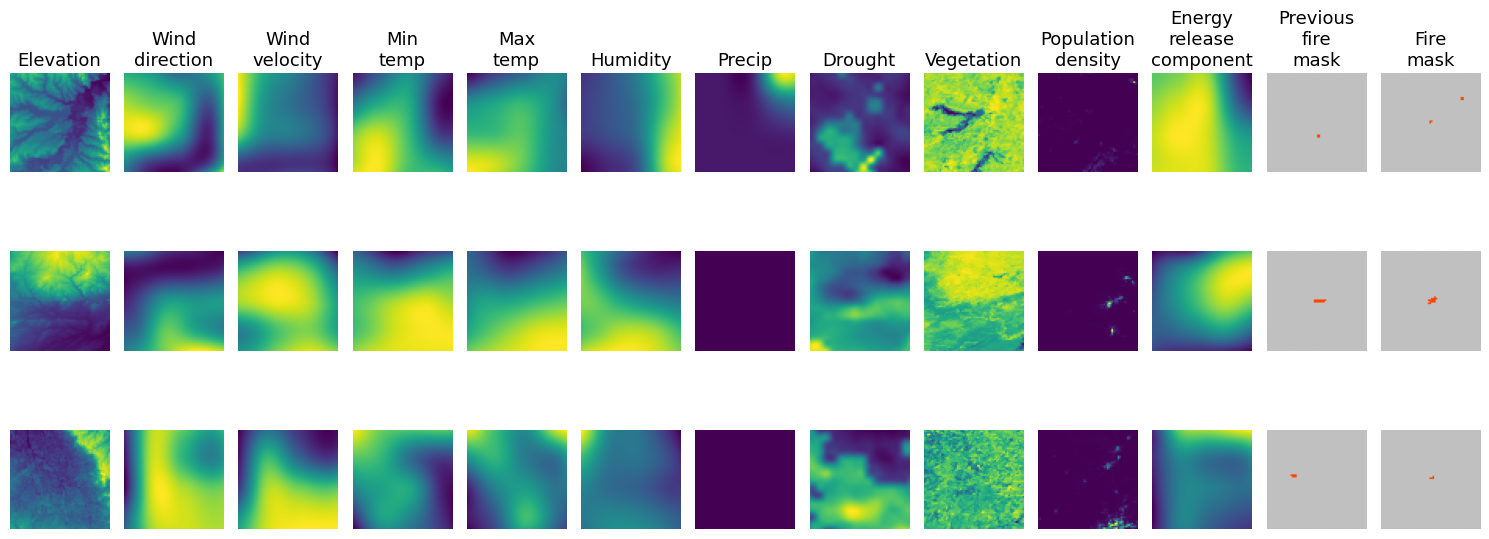

In [3]:
from load_dataset import visualise_n_samples
from load_dataset import get_dataset


dataset = get_dataset(
    file_pattern=f"../dataset/*{'train'}*.tfrecord",
    data_size=64,
    sample_size=64,
    batch_size=100000,
    num_in_channels=12,
    compression_type=None,
    clip_and_normalize=False,
    clip_and_rescale=False,
    random_crop=False,
    center_crop=False)

inputs, labels = next(iter(dataset))

visualise_n_samples( inputs=inputs, labels=labels, n_rows=3)

## Inspecting the fire mask


### Distribution of fire masks

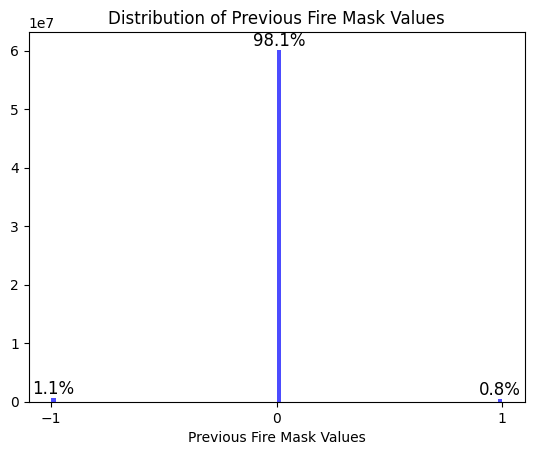

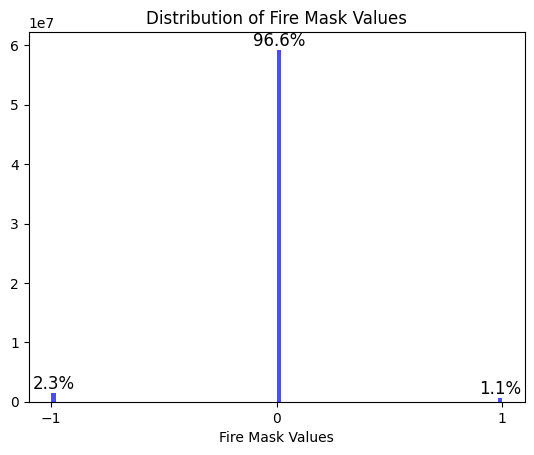

In [3]:


def plot_hist_with_percentages(data, bins, color, alpha, label):
    counts, bin_edges, patches = plt.hist(data, bins=bins, color=color, alpha=alpha, label=label)
    total = counts.sum()
    for count, edge_left, edge_right in zip(counts, bin_edges[:-1], bin_edges[1:]):
        if count > 0:
            percent = 100 * count / total
            plt.text((edge_left + edge_right) / 2, count, f'{percent:.1f}%', 
                     ha='center', va='bottom', fontsize=12, rotation=0)
                    
plot_hist_with_percentages(inputs[:, :, :, -1].numpy().flatten(), bins=100, color='blue', alpha=0.7, label='Previous Fire Mask')
plt.title('Distribution of Previous Fire Mask Values')
plt.xlabel('Previous Fire Mask Values')  
plt.xticks([-1, 0, 1])   
plt.show()
plot_hist_with_percentages(labels[:, :, :].numpy().flatten(), bins=100, color='blue', alpha=0.7, label='Fire Mask')
plt.title('Distribution of Fire Mask Values')
plt.xlabel('Fire Mask Values')
plt.xticks([-1, 0, 1])
plt.show()

In [5]:
# Calculate the number of samples where -1 appears in either inputs or labels
inputs_has_neg1 = (inputs[:, :, :, -1].numpy() == -1).any(axis=(1, 2))
labels_has_neg1 = (labels.numpy() == -1).any(axis=(1, 2, 3))
samples_with_neg1 = (inputs_has_neg1 | labels_has_neg1).sum()

print(f"Number of samples containing -1 in inputs or labels: {samples_with_neg1}")
print(f"Number of samples with -1 in the inputs: {inputs_has_neg1.sum()}")
print(f"Number of samples with -1 in the labels: {labels_has_neg1.sum()}")

#train has 14979 samples.
print("percentage of samples with -1 in inputs or labels: ", (samples_with_neg1 / 14979) * 100, "%")

Number of samples containing -1 in inputs or labels: 6649
Number of samples with -1 in the inputs: 4215
Number of samples with -1 in the labels: 4473
percentage of samples with -1 in inputs or labels:  44.38881100206956 %


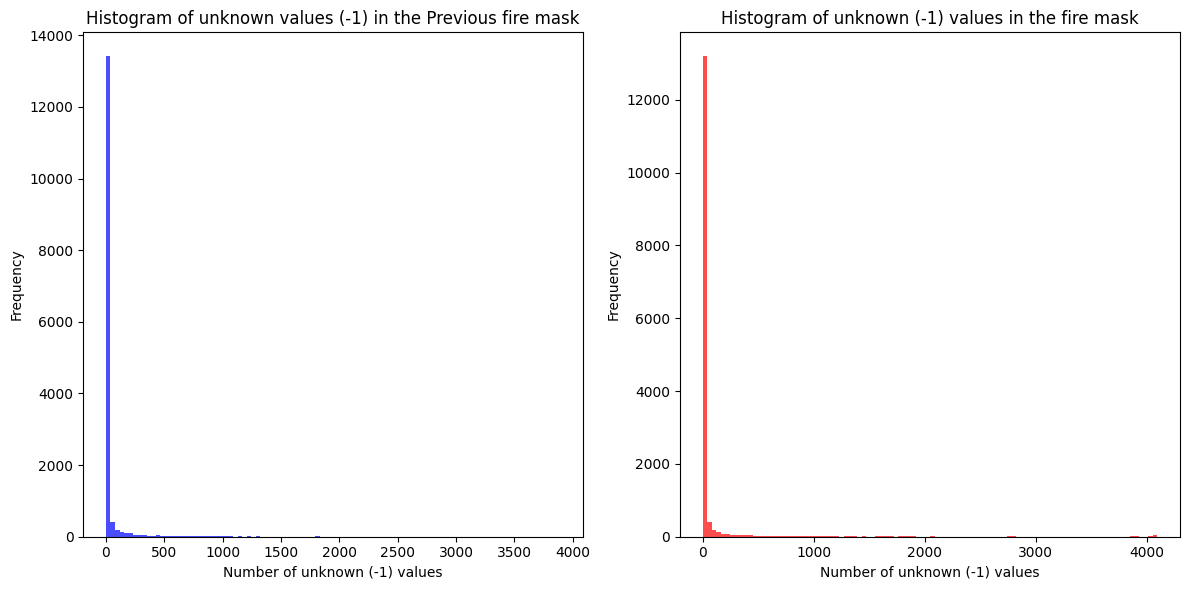

In [9]:
#histograms of -1 values per sample in inputs and labels
import matplotlib.pyplot as plt

# Get the number of -1 values per sample in inputs and labels
inputs_neg1_counts = (inputs[:, :, :, -1].numpy() == -1).sum(axis=(1, 2))
labels_neg1_counts = (labels.numpy() == -1).sum(axis=(1, 2, 3))

#remove 0 counts
# inputs_neg1_counts = inputs_neg1_counts[inputs_neg1_counts > 0]
# labels_neg1_counts = labels_neg1_counts[labels_neg1_counts > 0]

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(inputs_neg1_counts, bins=100, color='blue', alpha=0.7)
plt.title("Histogram of unknown values (-1) in the Previous fire mask")
plt.xlabel("Number of unknown (-1) values")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(labels_neg1_counts, bins=100, color='red', alpha=0.7)
plt.title("Histogram of unknown (-1) values in the fire mask")
plt.xlabel("Number of unknown (-1) values")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [5]:
#Number of samples without any fire in the input fire mask:
inputs_no_fire = (inputs[:, :, :, -1].numpy() == 0).all(axis=(1, 2))
samples_without_fire = inputs_no_fire.sum()
print(f"Number of samples without any fire in the input fire mask: {samples_without_fire}")
print("percentage of samples without any fire in the input fire mask: ", (samples_without_fire / 14979) * 100, "%")

Number of samples without any fire in the input fire mask: 0
percentage of samples without any fire in the input fire mask:  0.0 %


### Amount of shrinking and growing fires

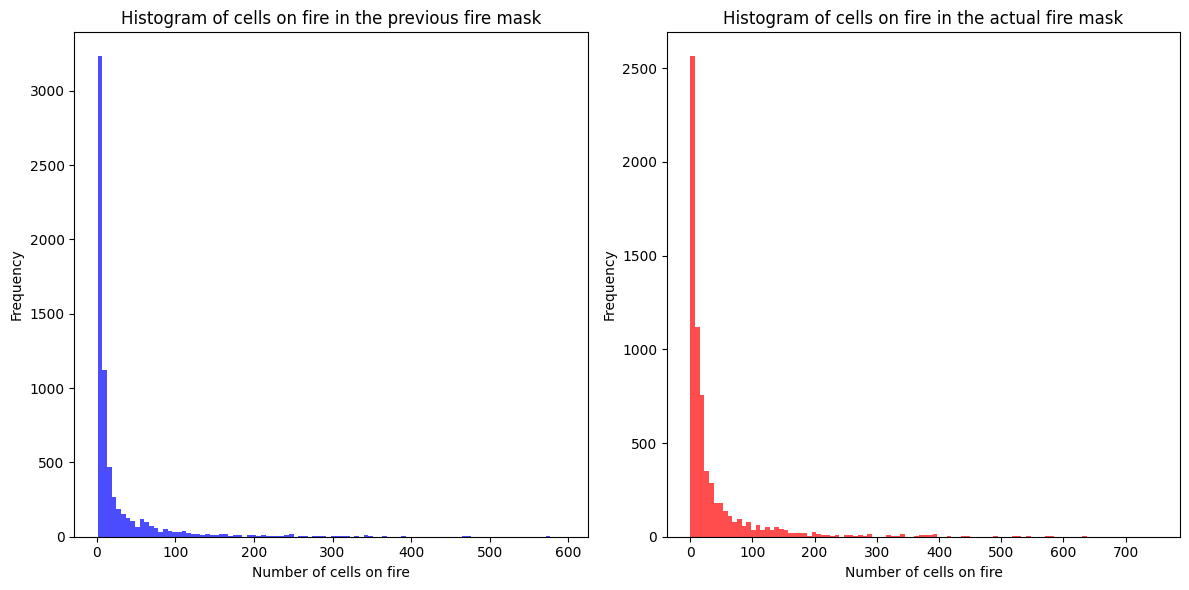

In [17]:
# Distribution of cells on fire per sample for the previous fire mask and fire mask.
# get count of cell on fire per sample
inputs_on_fire_counts = (inputs[:, :, :, -1].numpy() == 1).sum(axis=(1, 2))
labels_on_fire_counts = (labels.numpy() == 1).sum(axis=(1, 2, 3))
#histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(inputs_on_fire_counts, bins=100, color='blue', alpha=0.7)
plt.title("Histogram of cells on fire in the previous fire mask")
plt.xlabel("Number of cells on fire")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(labels_on_fire_counts, bins=100, color='red', alpha=0.7)
plt.title("Histogram of cells on fire in the actual fire mask")
plt.xlabel("Number of cells on fire")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [12]:
#Continuing with just the certain samples
inputs = inputs[inputs_has_neg1 | labels_has_neg1]
labels = labels[inputs_has_neg1 | labels_has_neg1]

Text(0.5, 0, 'Number of Cells')

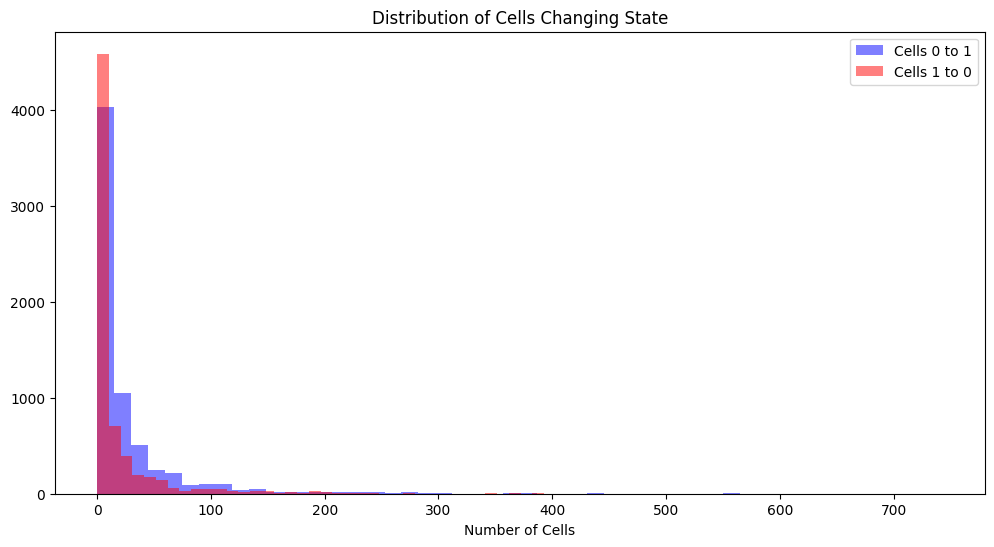

In [13]:
# Compare the previous fire mask and the fire mask. For each sample, count the cells that were 0 and became 1, and those that were 1 and became 0.
previous_fire_mask = inputs[:, :, :, -1].numpy()
fire_mask = labels[:,:,:,0].numpy()
cells_0_to_1 = ((previous_fire_mask == 0) & (fire_mask == 1)).sum(axis=(1, 2))
cells_1_to_0 = ((previous_fire_mask == 1) & (fire_mask== 0)).sum(axis=(1, 2))

# Plot the distribution of these counts
plt.figure(figsize=(12, 6)) 
plt.hist(cells_0_to_1, bins=50, alpha=0.5, label='Cells 0 to 1', color='blue')
plt.hist(cells_1_to_0, bins=50, alpha=0.5, label='Cells 1 to 0', color='red')
plt.title('Distribution of Cells Changing State')
plt.legend()
plt.xlabel('Number of Cells')   

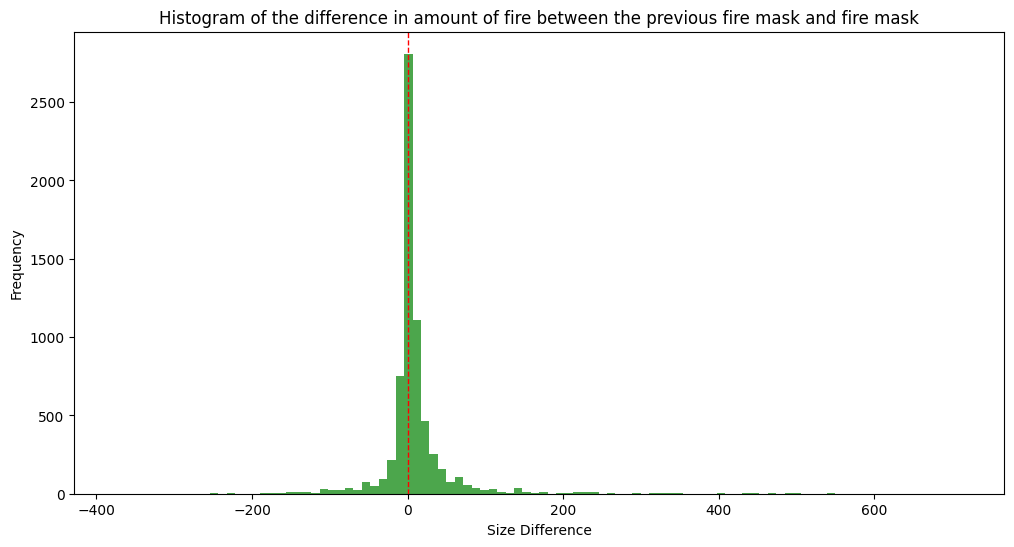

Number of samples with more cells growing than shrinking: 3627
Number of samples with more cells shrinking than growing: 2571
Number of samples with equal number of cells growing and shrinking: 451
Percentage of samples with more cells growing than shrinking: 54.55%
Percentage of samples with more cells shrinking than growing: 38.67%
Percentage of samples with equal number of cells growing and shrinking: 6.78%


In [16]:
#Size differences
differences = cells_0_to_1 - cells_1_to_0 #Growing - shrinking
plt.figure(figsize=(12, 6))
plt.hist(differences, bins=100, alpha=0.7, color='green')
plt.title('Histogram of the difference in amount of fire between the previous fire mask and fire mask')
plt.xlabel('Size Difference')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.show()
print(f"Number of samples with more cells growing than shrinking: {(differences > 0).sum()}")
print(f"Number of samples with more cells shrinking than growing: {(differences < 0).sum()}")
print(f"Number of samples with equal number of cells growing and shrinking: {(differences == 0).sum()}")
print(f"Percentage of samples with more cells growing than shrinking: {(differences > 0).sum() / len(differences) * 100:.2f}%")
print(f"Percentage of samples with more cells shrinking than growing: {(differences < 0).sum() / len(differences) * 100:.2f}%")
print(f"Percentage of samples with equal number of cells growing and shrinking: {(differences == 0).sum() / len(differences) * 100:.2f}%")

### Maximum distance traveled by each fire

Top 10 fire movement distances:
#1: Distance = 74.97, Index = 4669
#2: Distance = 70.84, Index = 2974
#3: Distance = 70.18, Index = 5115
#4: Distance = 70.01, Index = 1329
#5: Distance = 69.43, Index = 1423
#6: Distance = 69.30, Index = 3761
#7: Distance = 68.15, Index = 5082
#8: Distance = 67.21, Index = 5411
#9: Distance = 66.57, Index = 3008
#10: Distance = 66.57, Index = 3041


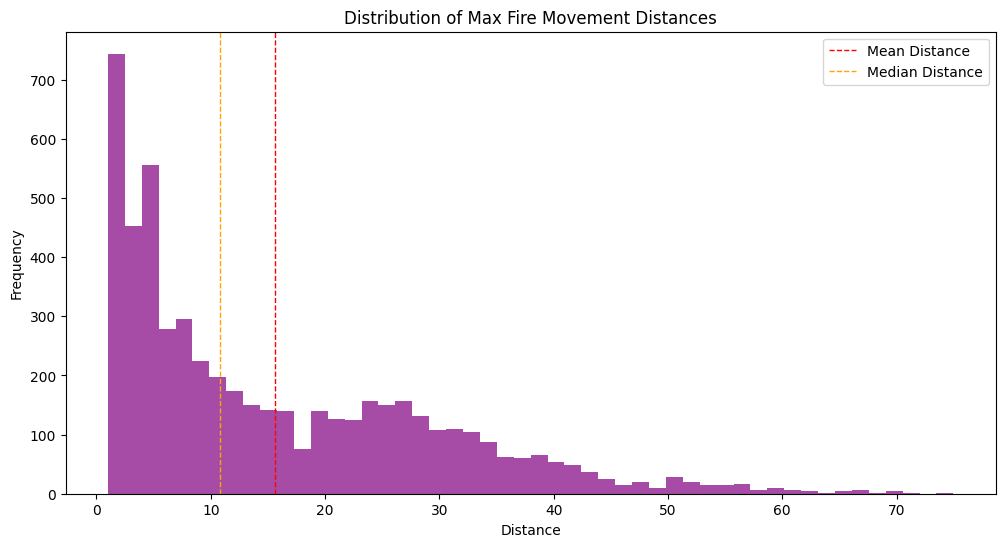

In [ ]:

def pairwise_euclidean(A, B):
    A_sq = np.sum(A**2, axis=1, keepdims=True)  # Sum of squares for A
    B_sq = np.sum(B**2, axis=1)  # Sum of squares for B
    AB = A @ B.T  # Dot product of A and B
    return np.sqrt(A_sq - 2 * AB + B_sq)  # Distance formula

# List to store the top 10 (distance, index) tuples
distances = []

for i in range(len(inputs)):  # Iterate over all occurrences
    prev_fire = np.argwhere(inputs[i, :, :, -1] > 0)  # Previous fire locations
    current_fire = np.argwhere(labels[i, :, :, 0] > 0)  # Current fire locations

    # Find new fire locations (present in current but not in previous)
    new_fire = [pt for pt in current_fire if tuple(pt) not in map(tuple, prev_fire)]
    new_fire = np.array(new_fire)

    if len(prev_fire) > 0 and len(new_fire) > 0:
        # Compute pairwise distances
        distances_for_all_fires = pairwise_euclidean(new_fire, prev_fire)

        # Get the minimum distance for each new fire pixel
        min_distances = np.min(distances_for_all_fires, axis=1)

        # Find the max of these minimum distances
        max_dist_in_frame = np.max(min_distances)

        # Store (distance, index)
        distances.append((max_dist_in_frame, i))


top_10_distances = sorted(distances, reverse=True, key=lambda x: x[0])[:10]
print("Top 10 fire movement distances:")
for rank, (dist, idx) in enumerate(top_10_distances, start=1):
    print(f"#{rank}: Distance = {dist:.2f}, Index = {idx}")

# distribution of distances
distances_array = np.array([dist for dist, _ in distances]) 
plt.figure(figsize=(12, 6))
plt.hist(distances_array, bins=50, alpha=0.7, color='purple')
plt.title('Distribution of Max Fire Movement Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.axvline(np.mean(distances_array), color='red', linestyle='dashed', linewidth=1, label='Mean Distance')
plt.axvline(np.median(distances_array), color='orange', linestyle='dashed', linewidth=1, label='Median Distance')
plt.legend()
plt.show()

Top 10 fire movement distances (Manhattan):
#1: Distance = 106.00, Index = 2656
#2: Distance = 106.00, Index = 14202
#3: Distance = 105.00, Index = 7364
#4: Distance = 100.00, Index = 10593
#5: Distance = 99.00, Index = 3666
#6: Distance = 99.00, Index = 14158
#7: Distance = 98.00, Index = 470
#8: Distance = 98.00, Index = 11921
#9: Distance = 98.00, Index = 14311
#10: Distance = 97.00, Index = 3705


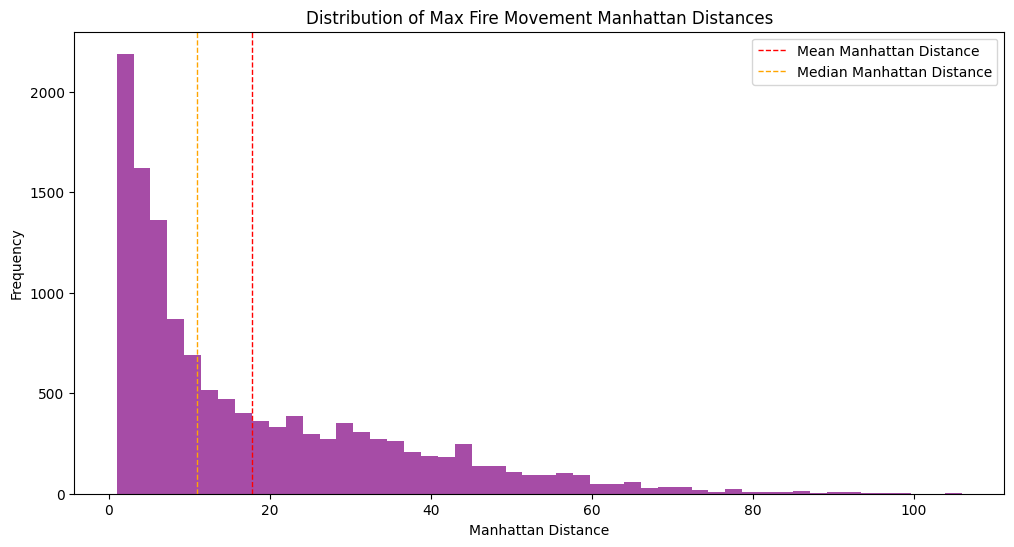

In [12]:
def pairwise_manhattan(A, B):
    return np.abs(A[:, 0, None] - B[:, 0]) + np.abs(A[:, 1, None] - B[:, 1])

# List to store the top 10 (distance, index) tuples
distances = []

for i in range(len(inputs)):
    prev_fire = np.argwhere(inputs[i, :, :, -1] > 0)
    current_fire = np.argwhere(labels[i, :, :, 0] > 0)
    new_fire = [pt for pt in current_fire if tuple(pt) not in map(tuple, prev_fire)]
    new_fire = np.array(new_fire)

    if len(prev_fire) > 0 and len(new_fire) > 0:
        distances_for_all_fires = pairwise_manhattan(new_fire, prev_fire)
        min_distances = np.min(distances_for_all_fires, axis=1)
        max_dist_in_frame = np.max(min_distances)
        distances.append((max_dist_in_frame, i))

top_10_distances = sorted(distances, reverse=True, key=lambda x: x[0])[:10]
print("Top 10 fire movement distances (Manhattan):")
for rank, (dist, idx) in enumerate(top_10_distances, start=1):
    print(f"#{rank}: Distance = {dist:.2f}, Index = {idx}")


# distribution of distances
distances_array = np.array([dist for dist, _ in distances]) 
plt.figure(figsize=(12, 6))
plt.hist(distances_array, bins=50, alpha=0.7, color='purple')
plt.title('Distribution of Max Fire Movement Manhattan Distances')
plt.xlabel('Manhattan Distance')
plt.ylabel('Frequency')
plt.axvline(np.mean(distances_array), color='red', linestyle='dashed', linewidth=1, label='Mean Manhattan Distance')
plt.axvline(np.median(distances_array), color='orange', linestyle='dashed', linewidth=1, label='Median Manhattan Distance')
plt.legend()
plt.show()

### Distance traveled of average fire position

Mean distance moved by average fire location: 11.209699523107467


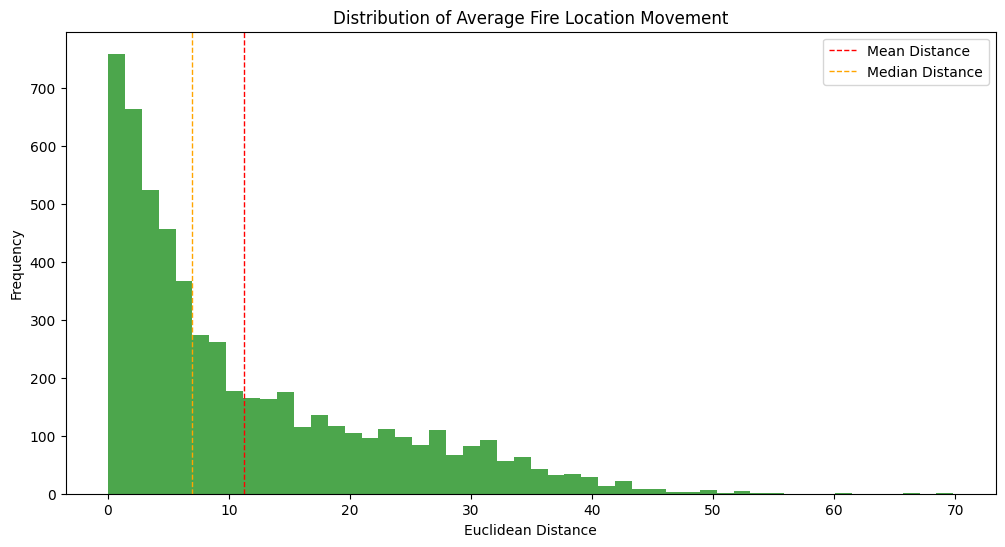

In [31]:
# Convert tensors to numpy arrays if needed
labels_np = labels.numpy()
previous_fire_mask_np = previous_fire_mask

avg_fire_locations = []
avg_prev_fire_locations = []
distances = []

for i in range(labels_np.shape[0]):
    # Actual fire mask (where == 1)
    fire_coords = np.argwhere(labels_np[i, :, :, 0] == 1)
    # Previous fire mask (where == 1)
    prev_fire_coords = np.argwhere(previous_fire_mask_np[i, :, :] == 1)
    
    if fire_coords.size > 0 and prev_fire_coords.size > 0:
        avg_fire = fire_coords.mean(axis=0)
        avg_prev_fire = prev_fire_coords.mean(axis=0)
        avg_fire_locations.append(avg_fire)
        avg_prev_fire_locations.append(avg_prev_fire)
        # Euclidean distance between averages
        distances.append(np.linalg.norm(avg_fire - avg_prev_fire))
    else:
        avg_fire_locations.append([np.nan, np.nan])
        avg_prev_fire_locations.append([np.nan, np.nan])
        distances.append(np.nan)

avg_fire_locations = np.array(avg_fire_locations)
avg_prev_fire_locations = np.array(avg_prev_fire_locations)
distances = np.array(distances)

print("Mean distance moved by average fire location:", np.nanmean(distances))

plt.figure(figsize=(12, 6))
plt.hist(distances[~np.isnan(distances)], bins=50, alpha=0.7, color='green')
plt.title('Distribution of Average Fire Location Movement')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.axvline(np.nanmean(distances), color='red', linestyle='dashed', linewidth=1, label='Mean Distance')
plt.axvline(np.nanmedian(distances), color='orange', linestyle='dashed', linewidth=1, label='Median Distance')
plt.legend()
plt.show()


Buffer Size Analysis Results:

Buffer Size: 0
  Overall Coverage: 100.00%
  Overall Missed: 0.00%
  Mean Event Coverage: 100.00% ± 0.00%
  Events with 100% coverage: 5532/5532

Buffer Size: 1
  Overall Coverage: 36.41%
  Overall Missed: 63.59%
  Mean Event Coverage: 32.19% ± 34.00%
  Events with 100% coverage: 388/5532

Buffer Size: 2
  Overall Coverage: 46.66%
  Overall Missed: 53.34%
  Mean Event Coverage: 40.98% ± 38.83%
  Events with 100% coverage: 677/5532

Buffer Size: 3
  Overall Coverage: 53.98%
  Overall Missed: 46.02%
  Mean Event Coverage: 46.67% ± 41.26%
  Events with 100% coverage: 1043/5532

Buffer Size: 4
  Overall Coverage: 59.52%
  Overall Missed: 40.48%
  Mean Event Coverage: 50.78% ± 42.45%
  Events with 100% coverage: 1335/5532

Buffer Size: 5
  Overall Coverage: 63.93%
  Overall Missed: 36.07%
  Mean Event Coverage: 53.96% ± 43.06%
  Events with 100% coverage: 1590/5532

Buffer Size: 7
  Overall Coverage: 70.61%
  Overall Missed: 29.39%
  Mean Event Coverage: 58.61

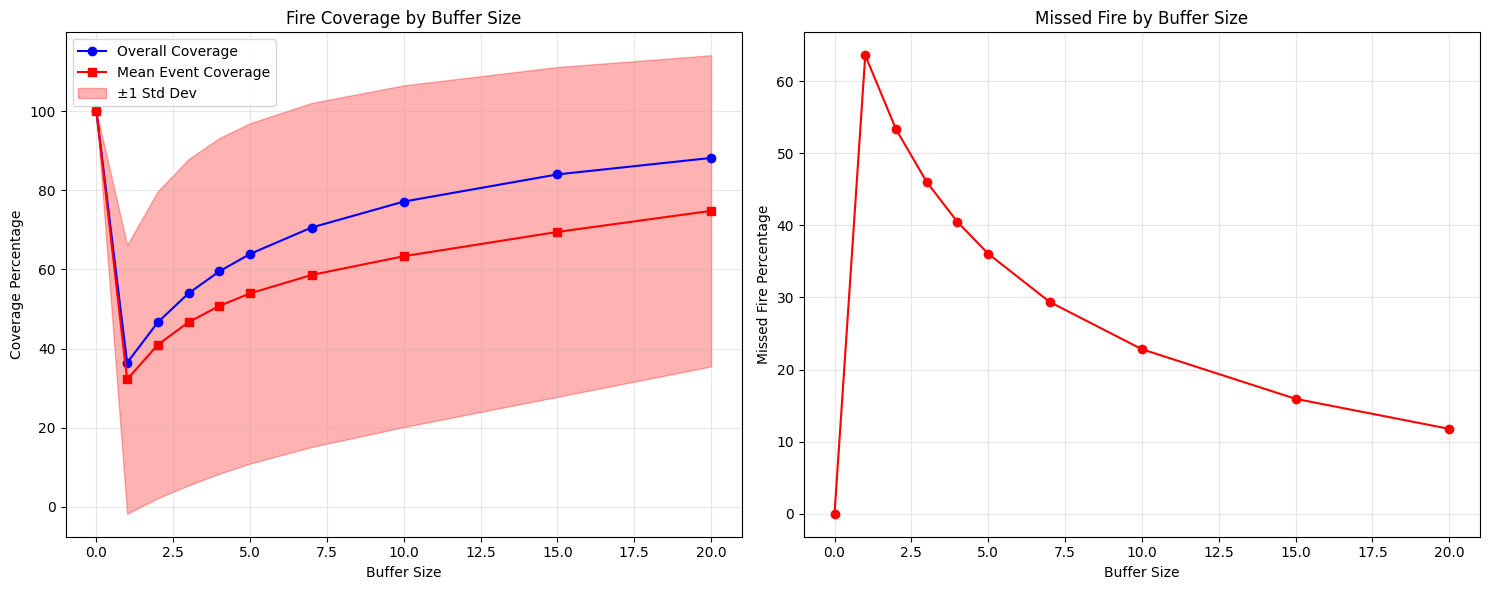

Buffer Size Analysis Results:

Buffer Size: 0
  Overall Coverage: 100.00%
  Overall Missed: 0.00%
  Mean Event Coverage: 100.00% ± 0.00%
  Events with 100% coverage: 5532/5532

Buffer Size: 1
  Overall Coverage: 36.41%
  Overall Missed: 63.59%
  Mean Event Coverage: 32.19% ± 34.00%
  Events with 100% coverage: 388/5532

Buffer Size: 2
  Overall Coverage: 46.66%
  Overall Missed: 53.34%
  Mean Event Coverage: 40.98% ± 38.83%
  Events with 100% coverage: 677/5532

Buffer Size: 3
  Overall Coverage: 53.98%
  Overall Missed: 46.02%
  Mean Event Coverage: 46.67% ± 41.26%
  Events with 100% coverage: 1043/5532

Buffer Size: 4
  Overall Coverage: 59.52%
  Overall Missed: 40.48%
  Mean Event Coverage: 50.78% ± 42.45%
  Events with 100% coverage: 1335/5532

Buffer Size: 5
  Overall Coverage: 63.93%
  Overall Missed: 36.07%
  Mean Event Coverage: 53.96% ± 43.06%
  Events with 100% coverage: 1590/5532

Buffer Size: 7
  Overall Coverage: 70.61%
  Overall Missed: 29.39%
  Mean Event Coverage: 58.61

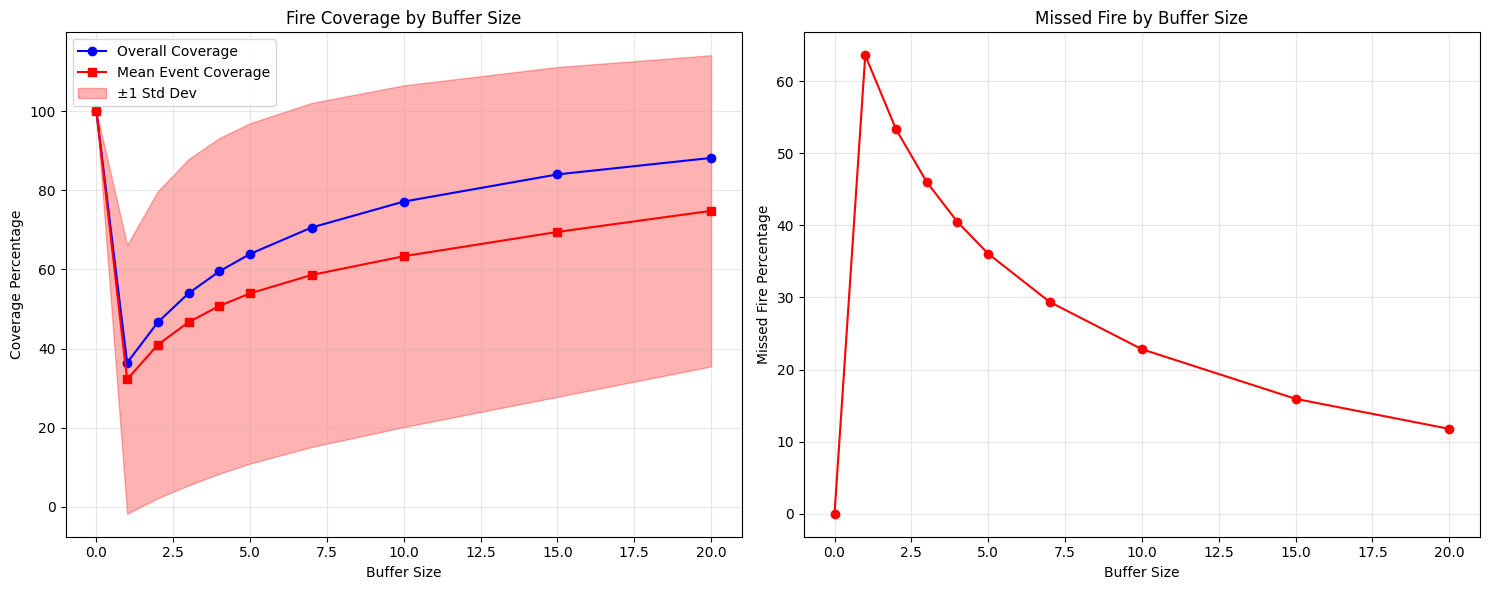

In [ ]:
# Amount of fires that would be missed by different buffer sizes
from scipy.ndimage import binary_dilation, label

def evaluate_buffer_coverage(data, labels, buffer_sizes, mask_channel=-1):
    """
    Evaluates how much fire in labels is missed for different buffer sizes.
    
    Parameters:
    - data: arraylike [events, x, y, covariates] - input data
    - labels: arraylike [events, x, y] - fire labels to evaluate coverage for
    - buffer_sizes: list of buffer sizes to test
    - mask_channel: int, which channel in data to use as binary mask (default -1 for last channel)
    
    Returns:
    - dict with buffer_size as key and coverage statistics as values
    """
    results = {}
    
    # Extract the binary mask (previous fire mask)
    binary_masks = data[:, :, :, mask_channel]
    
    for buffer_size in buffer_sizes:
        total_fire_pixels = 0
        covered_fire_pixels = 0
        missed_fire_pixels = 0
        coverage_per_event = []
        
        for event in range(data.shape[0]):
            # Get current event's masks
            prev_fire = binary_masks[event]
            current_fire = labels[event, :, :, 0] if len(labels.shape) == 4 else labels[event]
            
            # Skip if no fire in current labels
            if np.sum(current_fire > 0) == 0:
                continue
                
            # Create buffered mask from previous fire
            buffered_mask = binary_dilation(prev_fire > 0, iterations=buffer_size)
            
            # Count fire pixels in current labels
            fire_pixels = (current_fire > 0)
            total_fire_in_event = np.sum(fire_pixels)
            
            # Count how many fire pixels are covered by the buffer
            covered_fire_in_event = np.sum(fire_pixels & buffered_mask)
            missed_fire_in_event = total_fire_in_event - covered_fire_in_event
            
            # Calculate coverage percentage for this event
            coverage_pct = (covered_fire_in_event / total_fire_in_event) * 100 if total_fire_in_event > 0 else 0
            coverage_per_event.append(coverage_pct)
            
            # Accumulate totals
            total_fire_pixels += total_fire_in_event
            covered_fire_pixels += covered_fire_in_event
            missed_fire_pixels += missed_fire_in_event
        
        # Calculate overall statistics
        overall_coverage = (covered_fire_pixels / total_fire_pixels) * 100 if total_fire_pixels > 0 else 0
        overall_missed = (missed_fire_pixels / total_fire_pixels) * 100 if total_fire_pixels > 0 else 0
        
        results[buffer_size] = {
            'overall_coverage_pct': overall_coverage,
            'overall_missed_pct': overall_missed,
            'total_fire_pixels': total_fire_pixels,
            'covered_fire_pixels': covered_fire_pixels,
            'missed_fire_pixels': missed_fire_pixels,
            'mean_event_coverage': np.mean(coverage_per_event),
            'std_event_coverage': np.std(coverage_per_event),
            'min_event_coverage': np.min(coverage_per_event) if coverage_per_event else 0,
            'max_event_coverage': np.max(coverage_per_event) if coverage_per_event else 0,
            'events_with_perfect_coverage': np.sum(np.array(coverage_per_event) == 100),
            'events_evaluated': len(coverage_per_event)
        }
    
    return results

def plot_buffer_analysis(results):
    """
    Plot the results of buffer size analysis.
    """
    import matplotlib.pyplot as plt
    
    buffer_sizes = list(results.keys())
    overall_coverage = [results[bs]['overall_coverage_pct'] for bs in buffer_sizes]
    mean_coverage = [results[bs]['mean_event_coverage'] for bs in buffer_sizes]
    std_coverage = [results[bs]['std_event_coverage'] for bs in buffer_sizes]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Overall coverage
    ax1.plot(buffer_sizes, overall_coverage, 'b-o', label='Overall Coverage')
    ax1.plot(buffer_sizes, mean_coverage, 'r-s', label='Mean Event Coverage')
    ax1.fill_between(buffer_sizes, 
                     np.array(mean_coverage) - np.array(std_coverage),
                     np.array(mean_coverage) + np.array(std_coverage),
                     alpha=0.3, color='red', label='±1 Std Dev')
    ax1.set_xlabel('Buffer Size')
    ax1.set_ylabel('Coverage Percentage')
    ax1.set_title('Fire Coverage by Buffer Size')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Missed percentage
    missed_pct = [100 - cov for cov in overall_coverage]
    ax2.plot(buffer_sizes, missed_pct, 'r-o')
    ax2.set_xlabel('Buffer Size')
    ax2.set_ylabel('Missed Fire Percentage')
    ax2.set_title('Missed Fire by Buffer Size')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Usage example:
buffer_sizes = [0, 1, 2, 3, 4, 5, 7, 10, 15, 20]
results = evaluate_buffer_coverage(inputs, labels, buffer_sizes)

# Print results
print("Buffer Size Analysis Results:")
print("=" * 50)
for buffer_size, stats in results.items():
    print(f"\nBuffer Size: {buffer_size}")
    print(f"  Overall Coverage: {stats['overall_coverage_pct']:.2f}%")
    print(f"  Overall Missed: {stats['overall_missed_pct']:.2f}%")
    print(f"  Mean Event Coverage: {stats['mean_event_coverage']:.2f}% ± {stats['std_event_coverage']:.2f}%")
    print(f"  Events with 100% coverage: {stats['events_with_perfect_coverage']}/{stats['events_evaluated']}")

# Plot the results
plot_buffer_analysis(results)

def plot_buffer_analysis(results):
    """
    Plot the results of buffer size analysis.
    """
    import matplotlib.pyplot as plt
    
    buffer_sizes = list(results.keys())
    overall_coverage = [results[bs]['overall_coverage_pct'] for bs in buffer_sizes]
    mean_coverage = [results[bs]['mean_event_coverage'] for bs in buffer_sizes]
    std_coverage = [results[bs]['std_event_coverage'] for bs in buffer_sizes]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Overall coverage
    ax1.plot(buffer_sizes, overall_coverage, 'b-o', label='Overall Coverage')
    ax1.plot(buffer_sizes, mean_coverage, 'r-s', label='Mean Event Coverage')
    ax1.fill_between(buffer_sizes, 
                     np.array(mean_coverage) - np.array(std_coverage),
                     np.array(mean_coverage) + np.array(std_coverage),
                     alpha=0.3, color='red', label='±1 Std Dev')
    ax1.set_xlabel('Buffer Size')
    ax1.set_ylabel('Coverage Percentage')
    ax1.set_title('Fire Coverage by Buffer Size')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Missed percentage
    missed_pct = [100 - cov for cov in overall_coverage]
    ax2.plot(buffer_sizes, missed_pct, 'r-o')
    ax2.set_xlabel('Buffer Size')
    ax2.set_ylabel('Missed Fire Percentage')
    ax2.set_title('Missed Fire by Buffer Size')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Usage example:
buffer_sizes = [0, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 40, 50]
results = evaluate_buffer_coverage(inputs, labels, buffer_sizes)

# Print results
print("Buffer Size Analysis Results:")
print("=" * 50)
for buffer_size, stats in results.items():
    print(f"\nBuffer Size: {buffer_size}")
    print(f"  Overall Coverage: {stats['overall_coverage_pct']:.2f}%")
    print(f"  Overall Missed: {stats['overall_missed_pct']:.2f}%")
    print(f"  Mean Event Coverage: {stats['mean_event_coverage']:.2f}% ± {stats['std_event_coverage']:.2f}%")
    print(f"  Events with 100% coverage: {stats['events_with_perfect_coverage']}/{stats['events_evaluated']}")

# Plot the results
plot_buffer_analysis(results)

In [ ]:
# Percentage of samples with missed fire per buffer size


## Inspecting covariates

### Descriptive statistics

In [9]:
#get descriptive statistics for the dataset
import pandas as pd

inputs_np = inputs.numpy().reshape(-1, inputs.shape[-1])
df = pd.DataFrame(inputs_np, columns=[f'Channel_{i}' for i in range(inputs_np.shape[-1])])    

TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
]
df.columns = TITLES
df = df.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coerce errors to NaN
df = df.round(3)
df.columns = [title.replace('\n', ' ') for title in df.columns]
#dont allow e+ notation in pandas
pd.set_option('display.float_format', '{:.3f}'.format)
df.describe()  # Get descriptive statistics for the dataset

,Elevation,Wind direction,Wind velocity,Min temp,Max temp,Humidity,Precip,Drought,Vegetation,Population density,Energy release component,Previous fire mask
count,27234304.000,27234304.000,27234304.000,27234304.000,27234304.000,27234304.000,27234304.000,27234304.000,27234304.000,27234304.000,27234304.000,27234304.000
mean,787.636,117.802,3.673,281.137,296.134,0.007,0.580,-0.704,5295.146,36.538,46.981,-0.018
std,813.432,4180.296,1.341,20.794,21.827,0.004,2.063,2.509,2216.394,228.994,23.480,0.176
min,-8.000,-505870.062,-82.653,-444.693,0.000,-0.065,-167.448,-125.711,-9567.000,0.000,-1196.089,-1.000
25%,107.000,142.810,2.733,276.823,292.065,0.004,0.000,-2.636,3744.000,0.000,28.486,0.000
50%,373.000,199.090,3.478,282.595,298.478,0.006,0.000,-1.287,5465.000,0.374,39.681,0.000
75%,1442.000,247.621,4.416,288.171,303.513,0.008,0.091,1.313,7035.000,4.755,67.288,0.000
max,4148.000,37735.629,103.220,441.820,1108.232,0.086,56.215,52.269,9966.000,27103.605,1570.781,1.000


### Histograms of the distributions

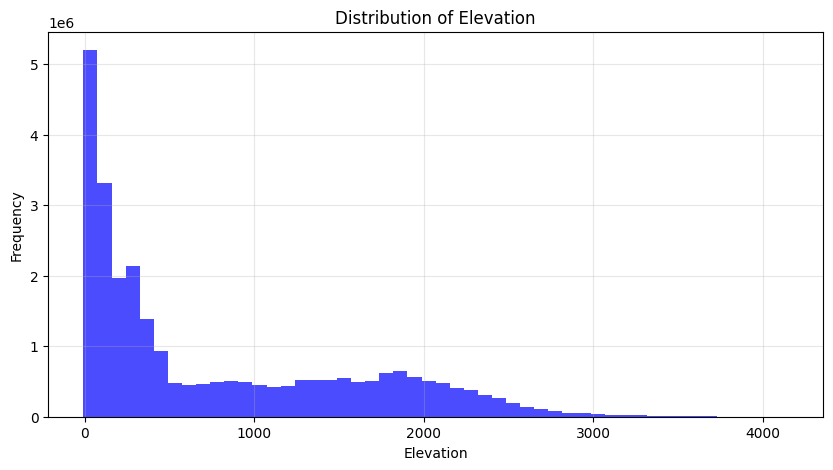

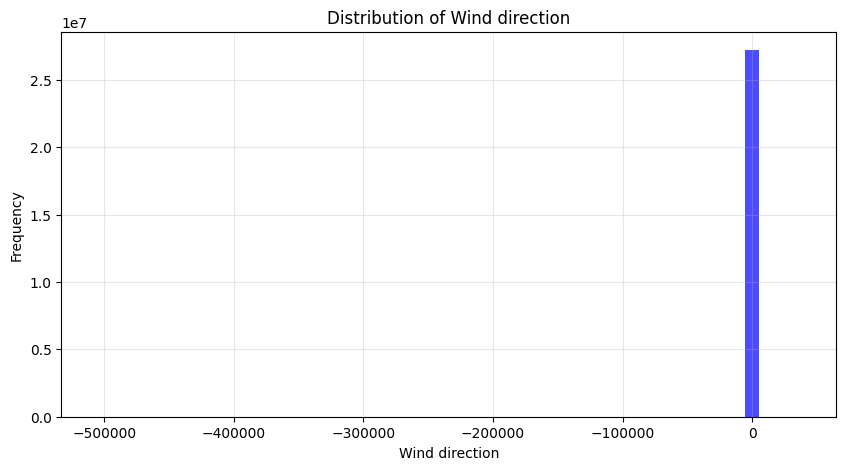

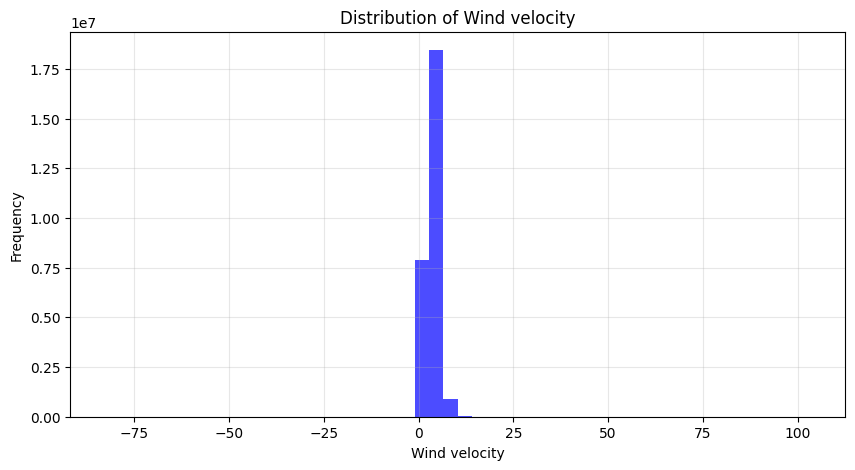

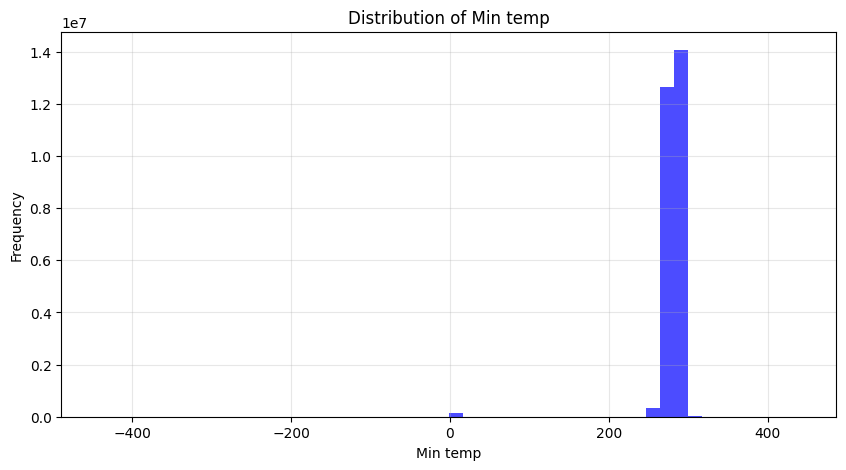

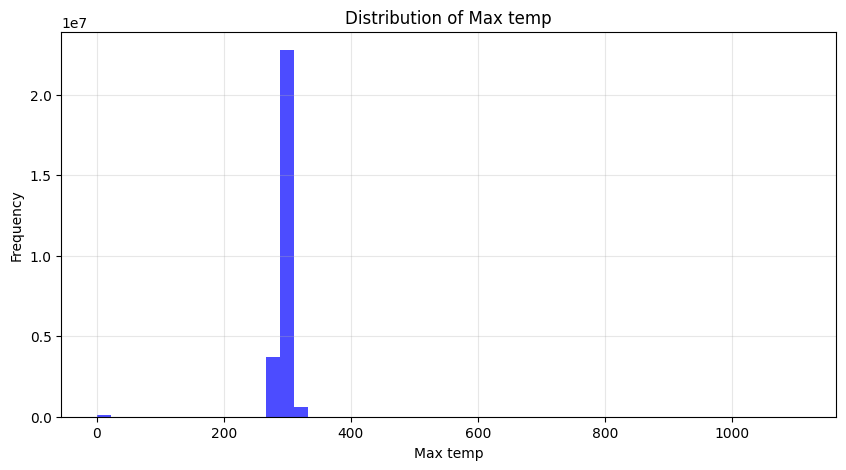

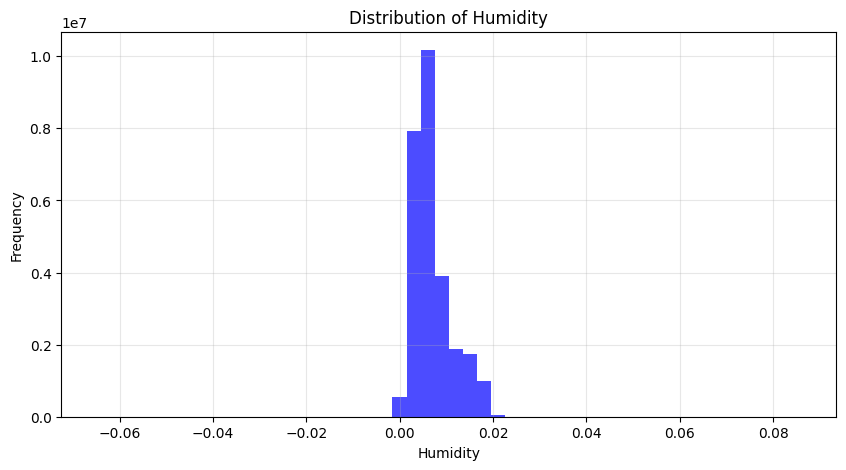

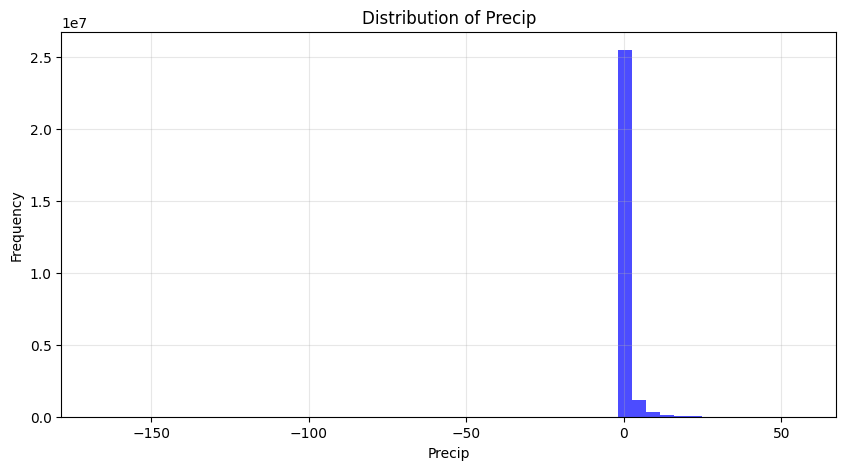

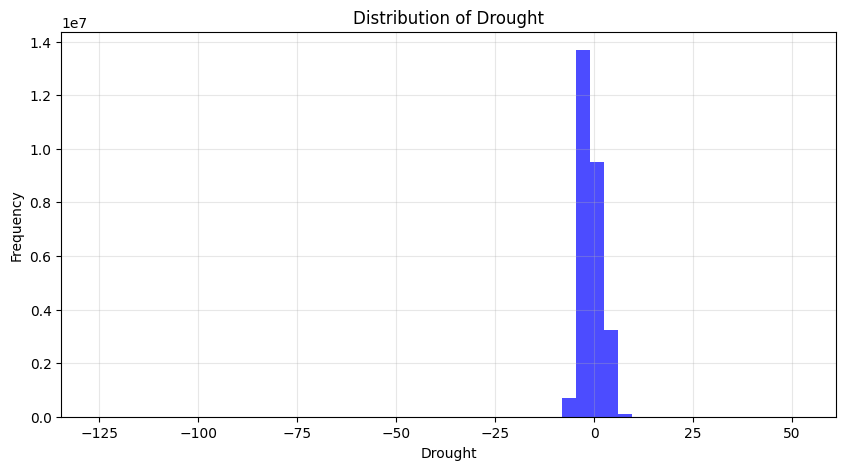

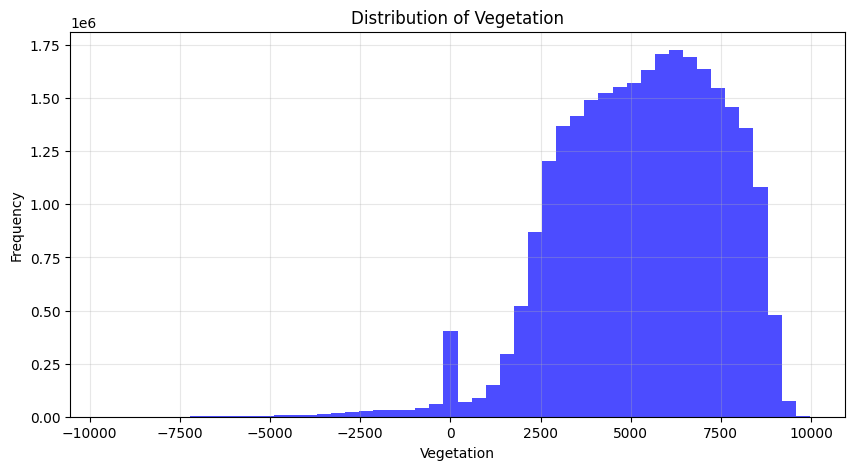

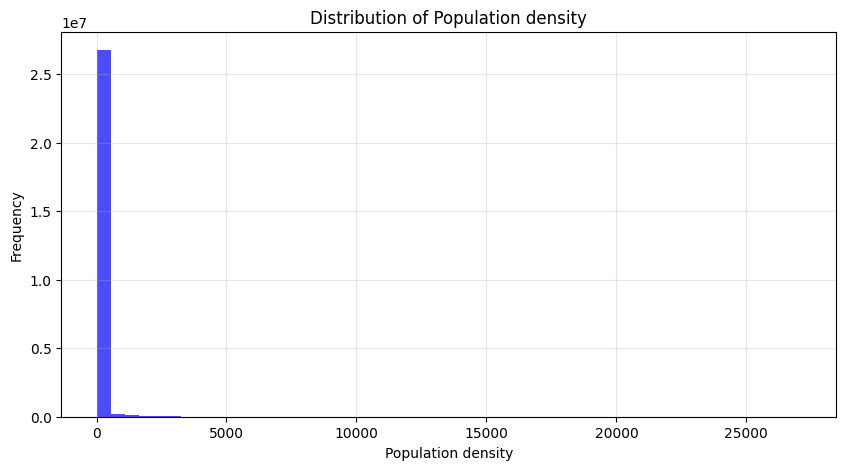

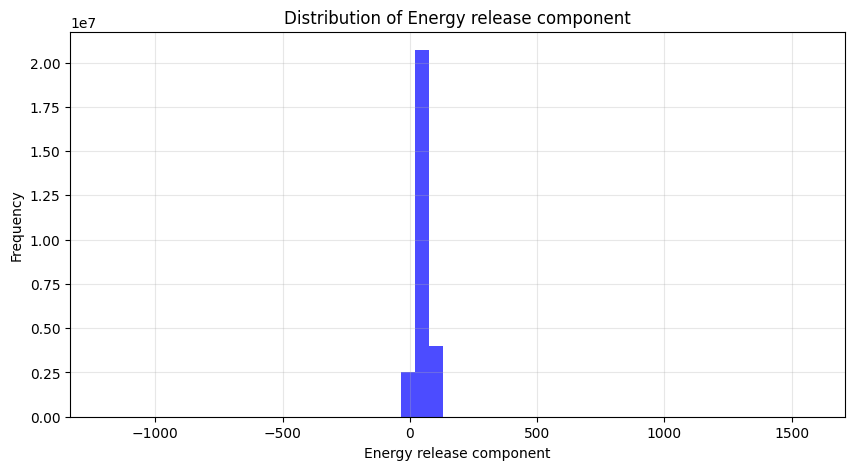

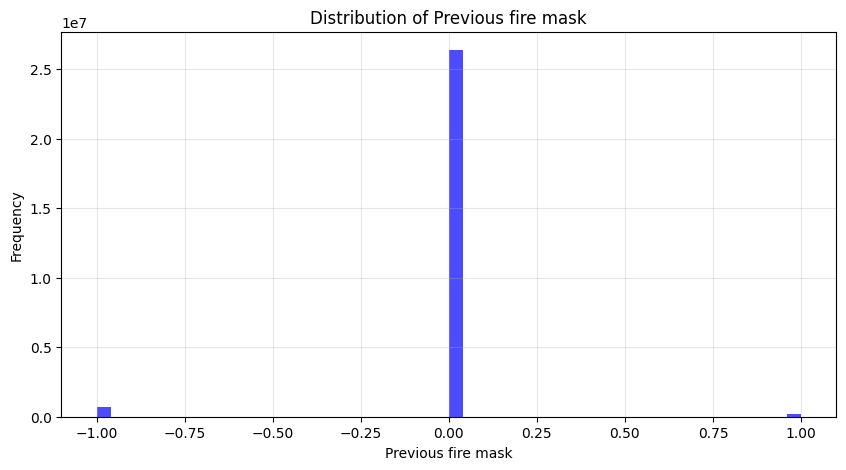

In [13]:
#create histograms for each channel
import matplotlib.pyplot as plt
for column in df.columns:
    plt.figure(figsize=(10, 5))
    plt.hist(df[column].dropna(), bins=50, alpha=0.7, color='blue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()

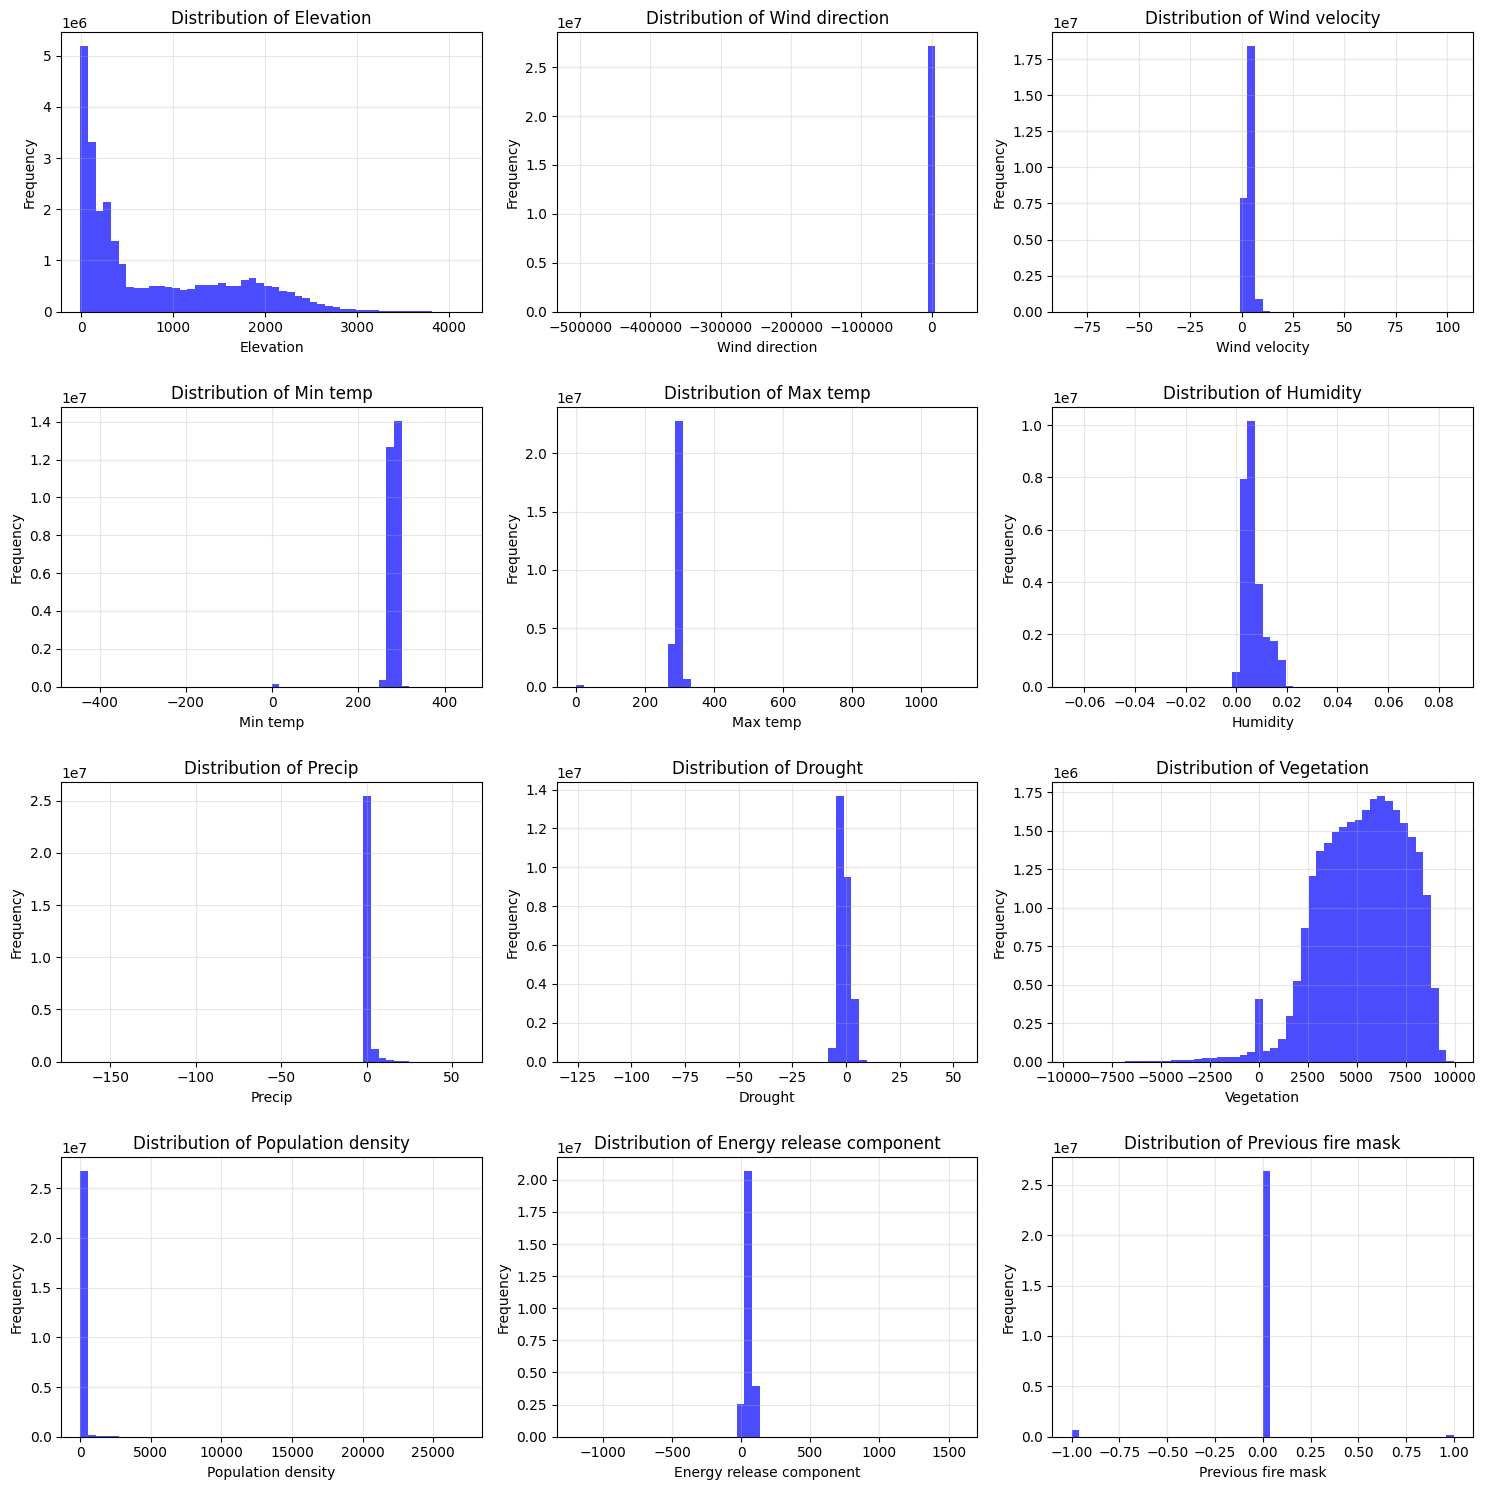

In [10]:
#histograms in one figure
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
axes = axes.flatten()
for i, column in enumerate(df.columns):
    axes[i].hist(df[column].dropna(), bins=50, alpha=0.7, color='blue')
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

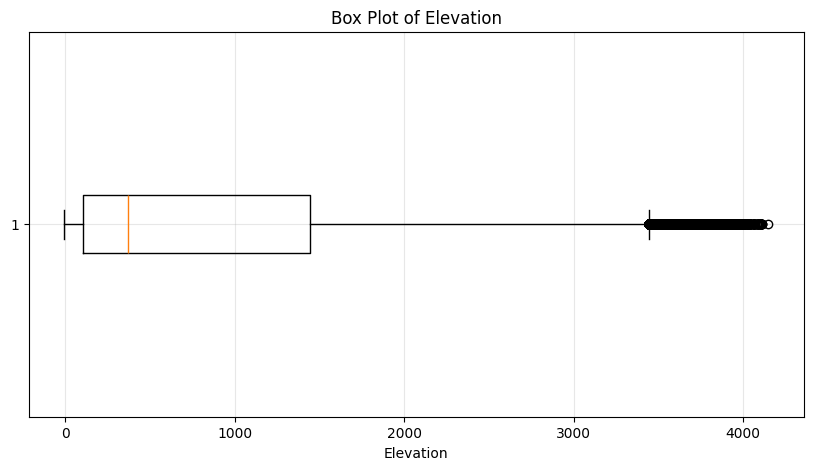

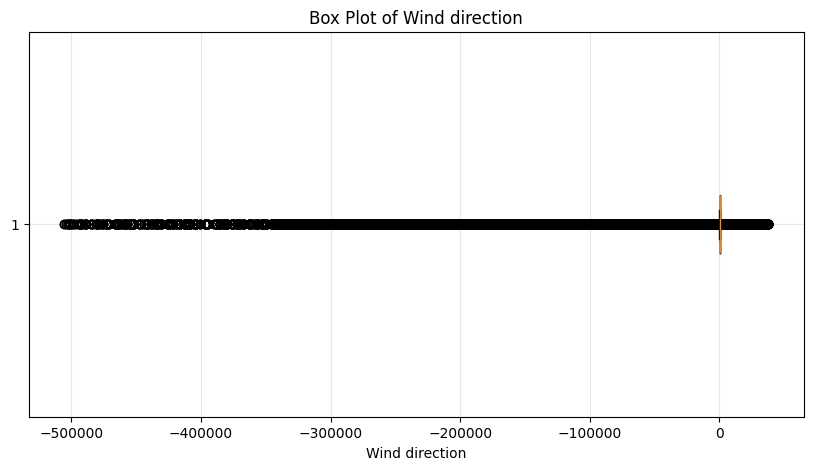

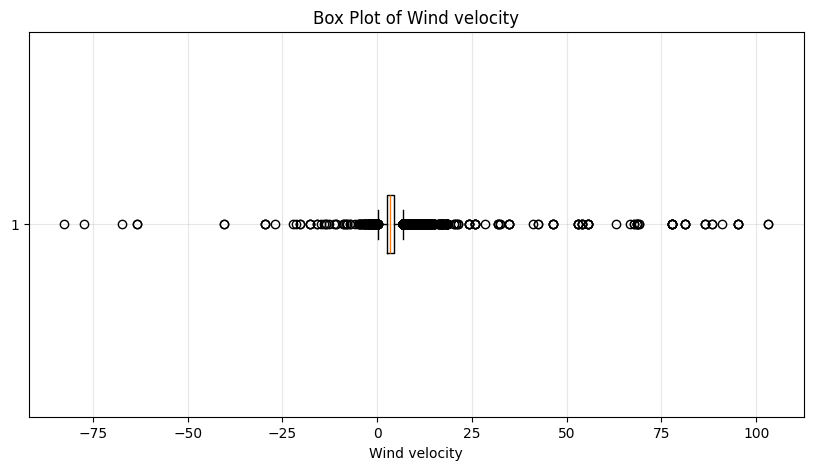

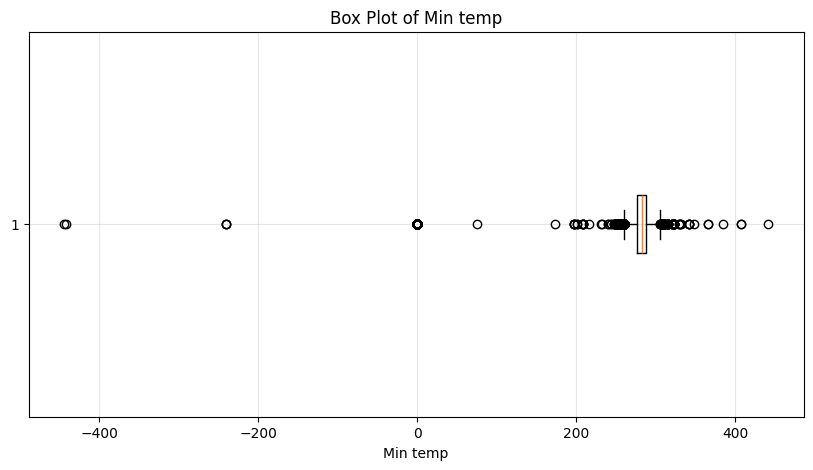

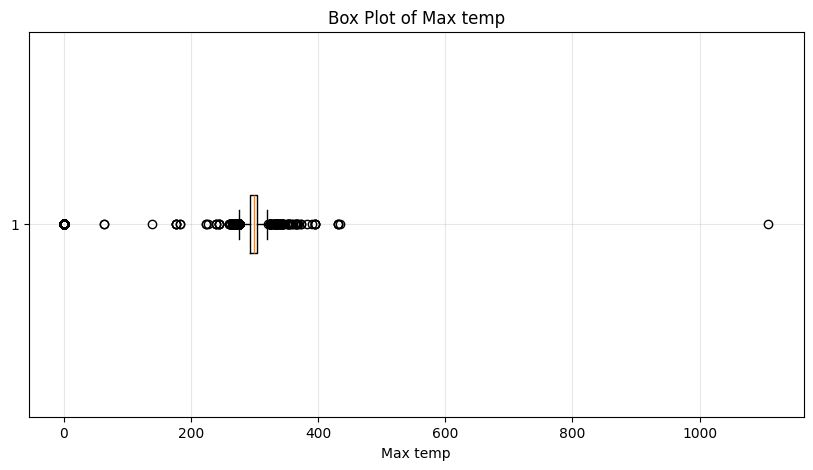

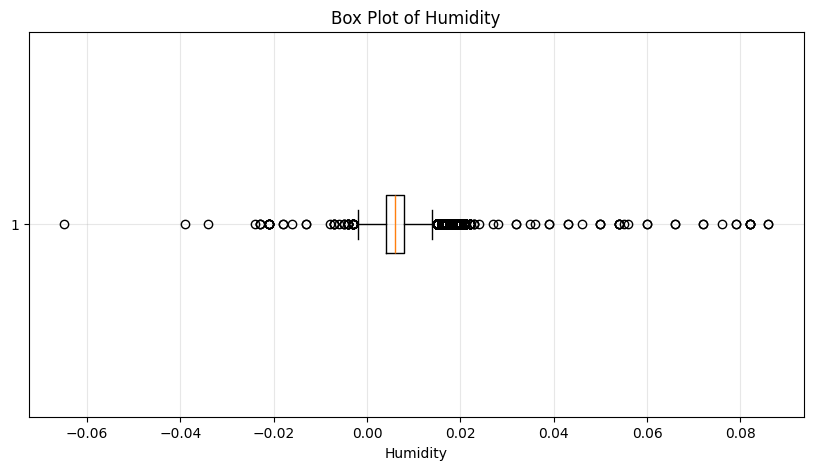

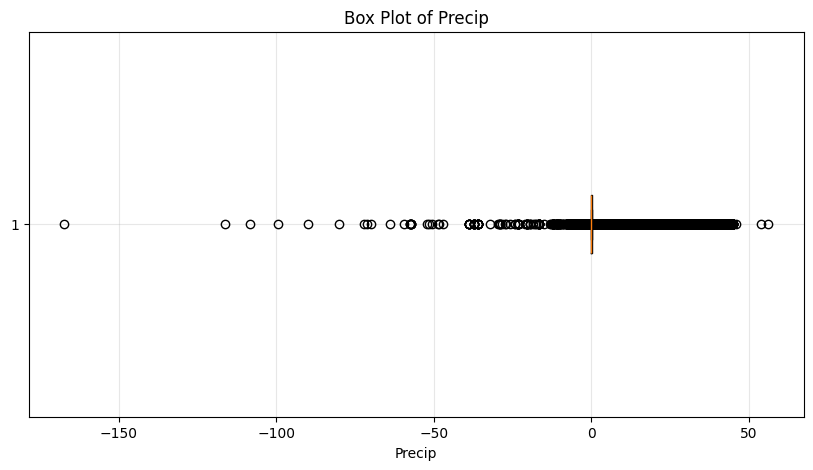

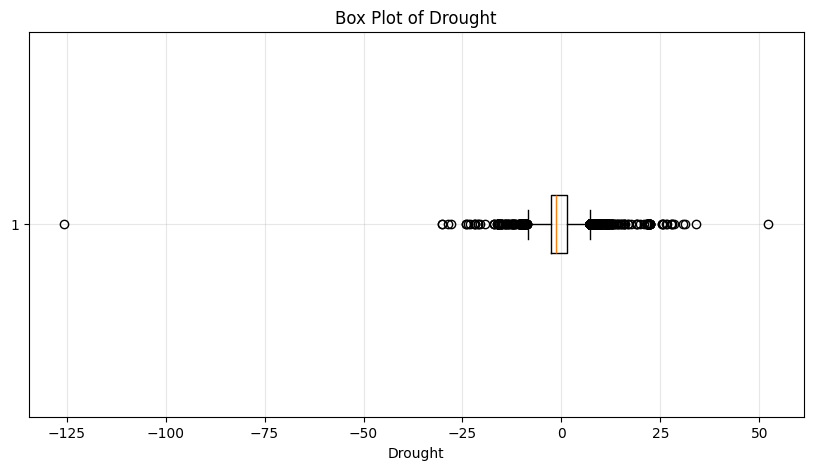

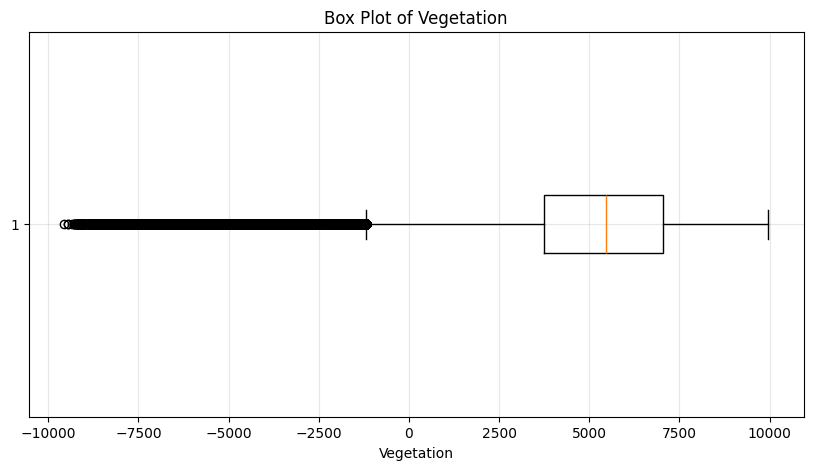

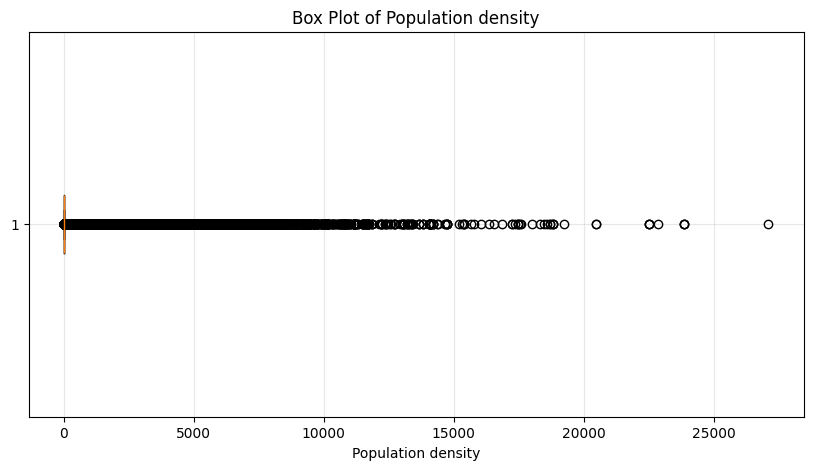

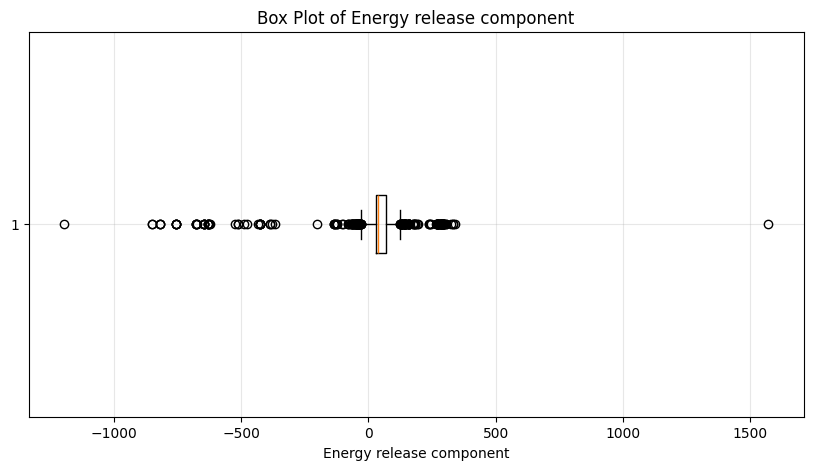

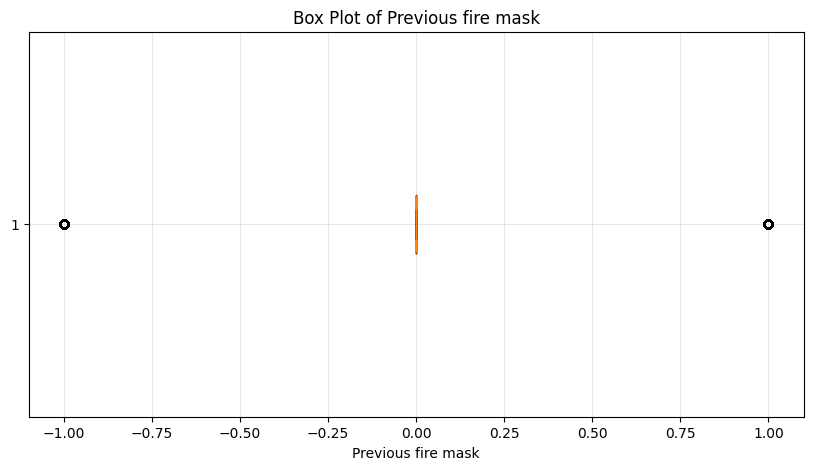

In [14]:
# box plots for each channel
for column in df.columns:
    plt.figure(figsize=(10, 5))
    plt.boxplot(df[column].dropna(), vert=False)
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.grid(True, alpha=0.3)
    plt.show()

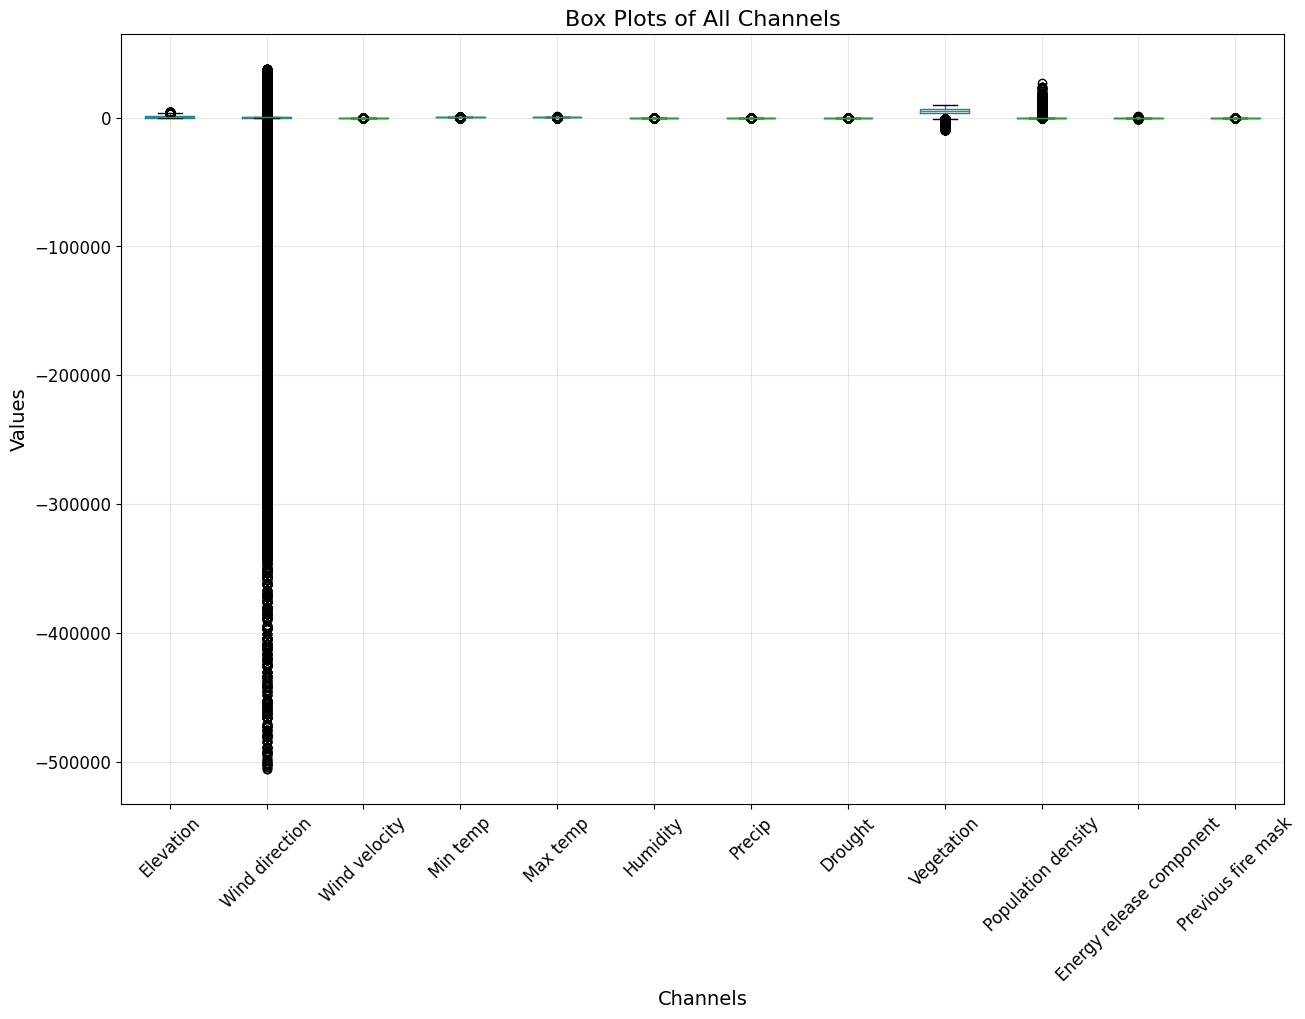

In [16]:
#all boxplots in one figure
plt.figure(figsize=(15, 10))
df.boxplot(rot=45, fontsize=12)
plt.title('Box Plots of All Channels', fontsize=16)
plt.xlabel('Channels', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

In [12]:


DATA_STATS = { #DATA_STATS as provided by the data reader and visualization notebook of the Next Day Wildfire dataset for loading the data:
    # https://www.kaggle.com/code/fantineh/data-reader-and-visualization

    # For each variable, the statistics are ordered in the form:
    # (min_clip, max_clip, mean, standard deviation)


    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'Elevation': (0.0, 3141.0, 657.3003, 649.0147),

    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'wind direction': (0., 360.0, 190.32976, 72.59854),

    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'Wind velocity': (0.0, 10.024310074806237, 3.8500874, 1.4109988),

    
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'Min temp': (253.15, 298.94891357421875, 281.08768, 8.982386),
    # -20 degree C, 99.9 percentile
    'Max temp': (253.15, 315.09228515625, 295.17383, 9.815496),
    
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'Humidity': (0., 1., 0.0071658953, 0.0042835088),
    
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'Precipitation': (0.0, 44.53038024902344, 1.7398051, 4.482833),

    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),

    'Vegetation': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max


    
    'Population density': (0., 2534.06298828125, 25.531384, 154.72331),
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data

    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    # Population density
    # min, 99.9 percentile

    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
} 

TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]


def count_outliers(data, stats):
    """
    Count the number of outliers in the dataset based on the provided statistics.
    Uses column index instead of name for compatibility with different wording.
    
    Parameters:
    - data: DataFrame containing the dataset.
    - stats: Dictionary containing the statistics for each variable.
    
    Returns:
    - Dictionary with variable names as keys and number of outliers as values.
    """
    outliers_count = {}
    for idx, (key, (min_clip, max_clip, _, _)) in enumerate(stats.items()):
        if idx >= len(data.columns):
            continue
        col = data.columns[idx]
        outliers_below = (data[col] < min_clip).sum()
        outliers_above = (data[col] > max_clip).sum()
        outliers_count[key] = outliers_below + outliers_above
    return outliers_count

outliers = count_outliers(df, DATA_STATS)
print("Outliers count for each variable:")
for variable, count in outliers.items():
    print(f"{variable}: {count} outliers")

Outliers count for each variable:
Elevation: 105383 outliers
wind direction: 68373 outliers
Wind velocity: 23696 outliers
Min temp: 221185 outliers
Max temp: 214510 outliers
Humidity: 97 outliers
Precipitation: 2380742 outliers
pdsi: 16272 outliers
Vegetation: 0 outliers
Population density: 49538 outliers
erc: 83805 outliers
PrevFireMask: 0 outliers


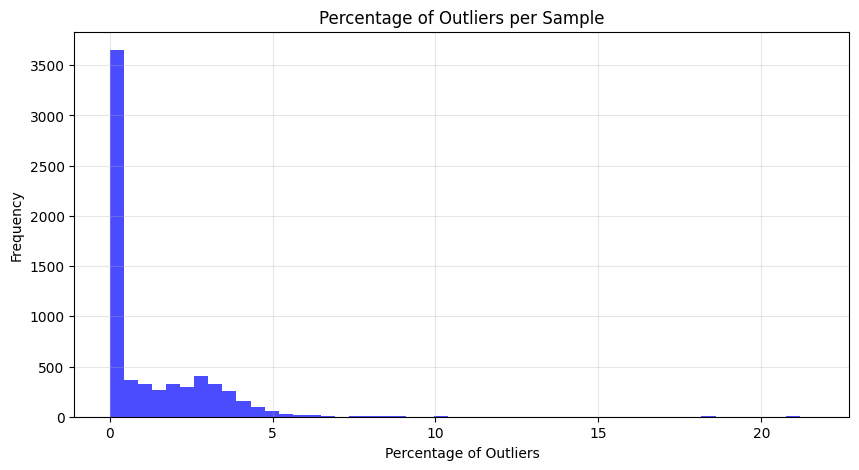

In [14]:
# Count percentage of cells with outliers per sample
samples_with_outliers_pct = []
import numpy as np
# Get lower and upper bounds for each covariate
covariate_keys = list(DATA_STATS.keys())[:inputs.shape[-1]]
lower_bounds = np.array([DATA_STATS[key][0] for key in covariate_keys])
upper_bounds = np.array([DATA_STATS[key][1] for key in covariate_keys])

inputs_np = inputs.numpy()  # shape: [samples, x, y, covariate]
num_cells = inputs_np.shape[1] * inputs_np.shape[2] * inputs_np.shape[3]

for sample in inputs_np:
    # sample shape: [x, y, covariate]
    outlier_mask = (sample < lower_bounds) | (sample > upper_bounds)
    outlier_count = np.sum(outlier_mask)
    samples_with_outliers_pct.append(outlier_count / (sample.shape[0] * sample.shape[1] * sample.shape[2]) * 100)
#
#show histogram of percentage of outliers per sample
plt.figure(figsize=(10, 5))
plt.hist(samples_with_outliers_pct, bins=50, alpha=0.7, color='blue')
plt.title('Percentage of Outliers per Sample')
plt.xlabel('Percentage of Outliers')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

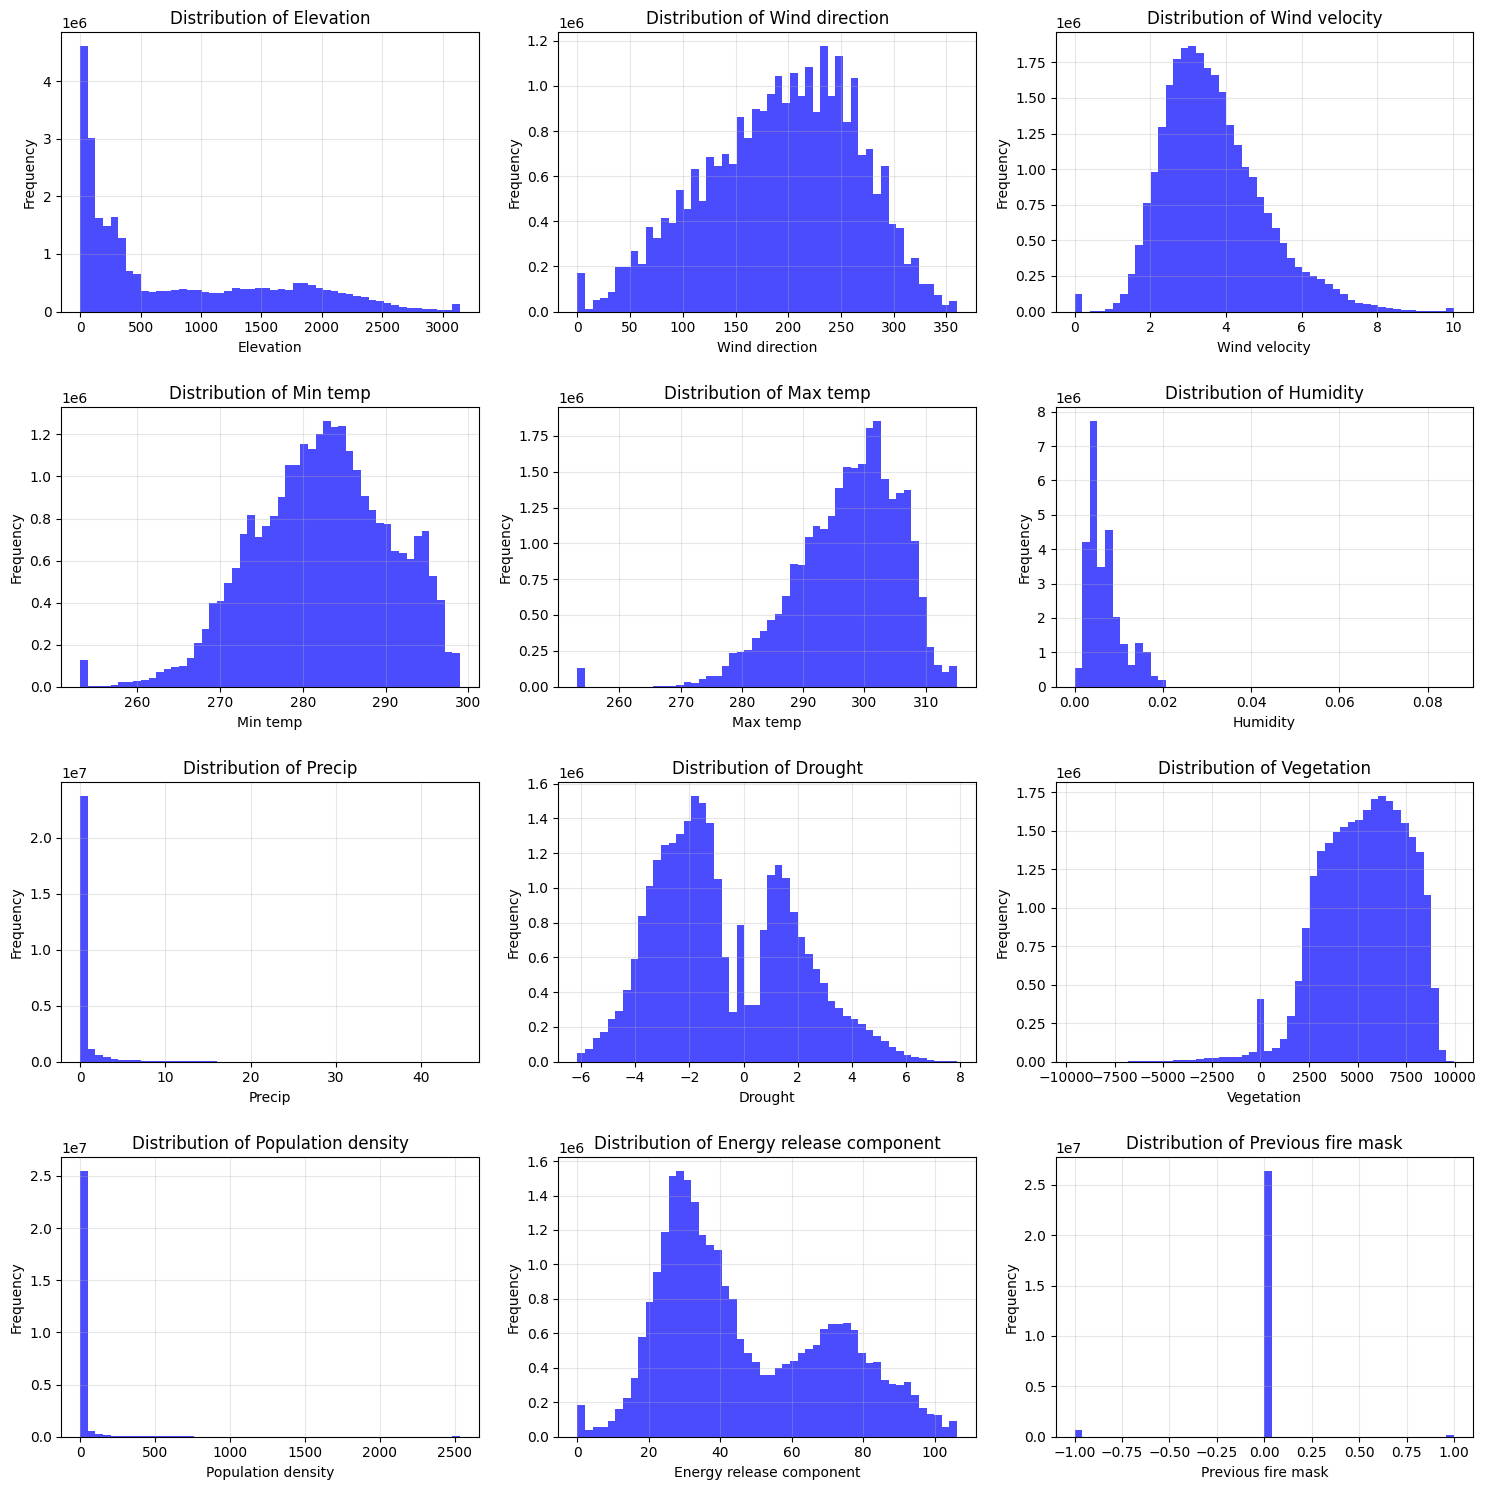

In [15]:
#clamp outliers to the min and max values
def clamp_outliers(data, stats):
    """
    Clamp outliers in the dataset based on the provided statistics.
    Uses column index instead of name for compatibility with different wording.
    
    Parameters:
    - data: DataFrame containing the dataset.
    - stats: Dictionary containing the statistics for each variable.
    
    Returns:
    - DataFrame with outliers clamped to min and max values.
    """
    clamped_data = data.copy()
    for idx, (key, (min_clip, max_clip, _, _)) in enumerate(stats.items()):
        if idx >= len(data.columns):
            continue
        col = data.columns[idx]
        clamped_data[col] = np.clip(clamped_data[col], min_clip, max_clip)
    return clamped_data

clamped_df = clamp_outliers(df, DATA_STATS)

 #show histograms of each feature in the clamped dataframe in one figure
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
axes = axes.flatten()
for i, column in enumerate(clamped_df.columns):
    axes[i].hist(clamped_df[column].dropna(), bins=50, alpha=0.7, color='blue')
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
 

### Correlations

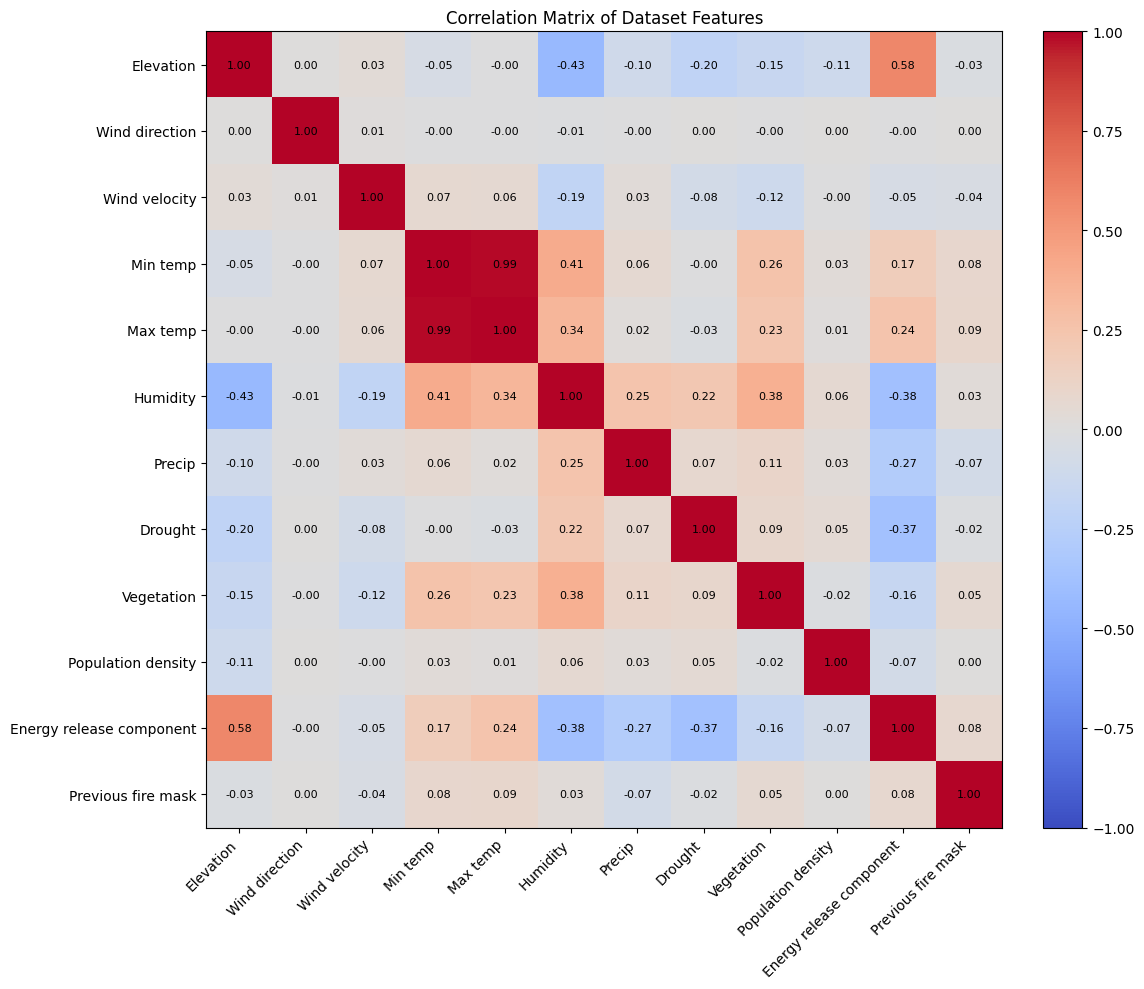

In [22]:
# Correlation matrix using matplotlib only
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
im = plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(df.columns)), df.columns, rotation=45, ha='right', fontsize=10)
plt.yticks(range(len(df.columns)), df.columns, fontsize=10)
plt.title('Correlation Matrix of Dataset Features')
# Annotate correlation values
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black', fontsize=8)
plt.tight_layout()
plt.show()

### Visualization for report

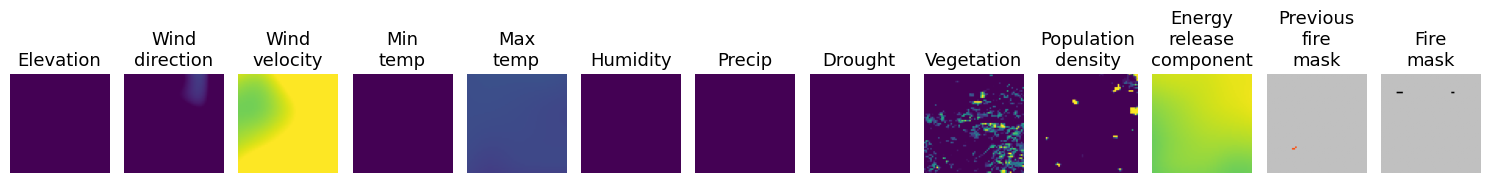

In [23]:
dataset = get_dataset(
    file_pattern=f"../dataset/*{'test'}*.tfrecord",
    data_size=64,
    sample_size=64,
    batch_size=100000,
    num_in_channels=12,
    compression_type=None,
    clip_and_normalize=True,
    clip_and_rescale=False,
    random_crop=False,
    center_crop=False)

inputs, labels = next(iter(dataset))

visualise_n_samples( inputs=inputs, labels=labels, n_rows=1, show_sample=4)

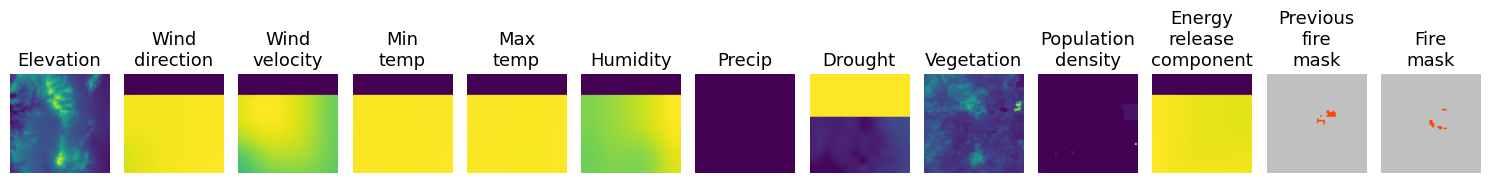

In [10]:

visualise_n_samples( inputs=inputs, labels=labels, n_rows=1, show_sample=3)

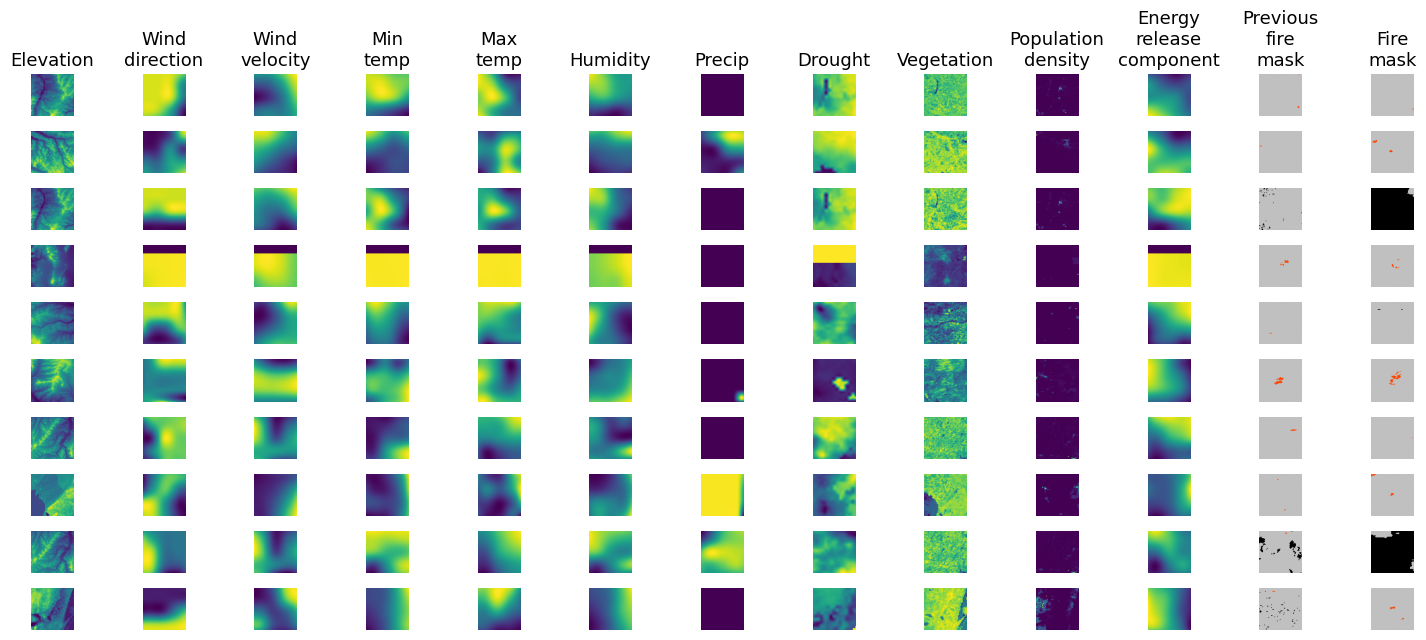

In [11]:
visualise_n_samples( inputs=inputs, labels=labels, n_rows=10, show_sample=0)

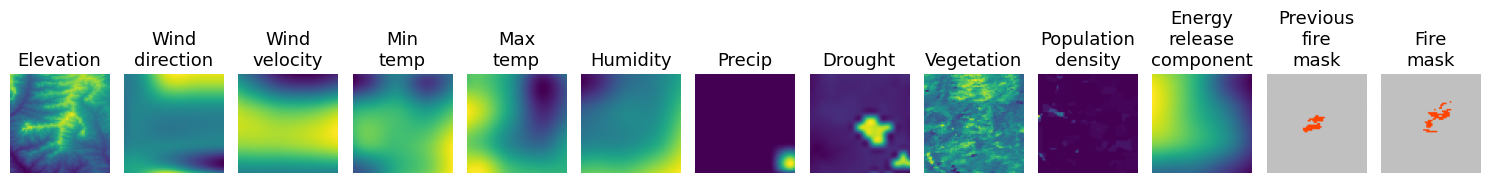

In [14]:
visualise_n_samples( inputs=inputs, labels=labels, n_rows=1, show_sample=5)

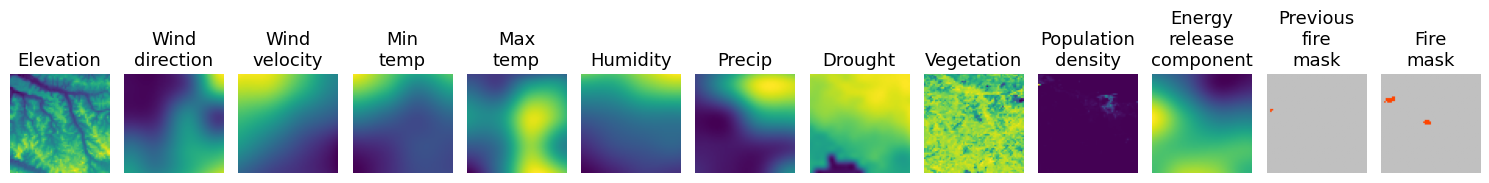

In [16]:
visualise_n_samples( inputs=inputs, labels=labels, n_rows=1, show_sample=1)

### Normalized visualisations:


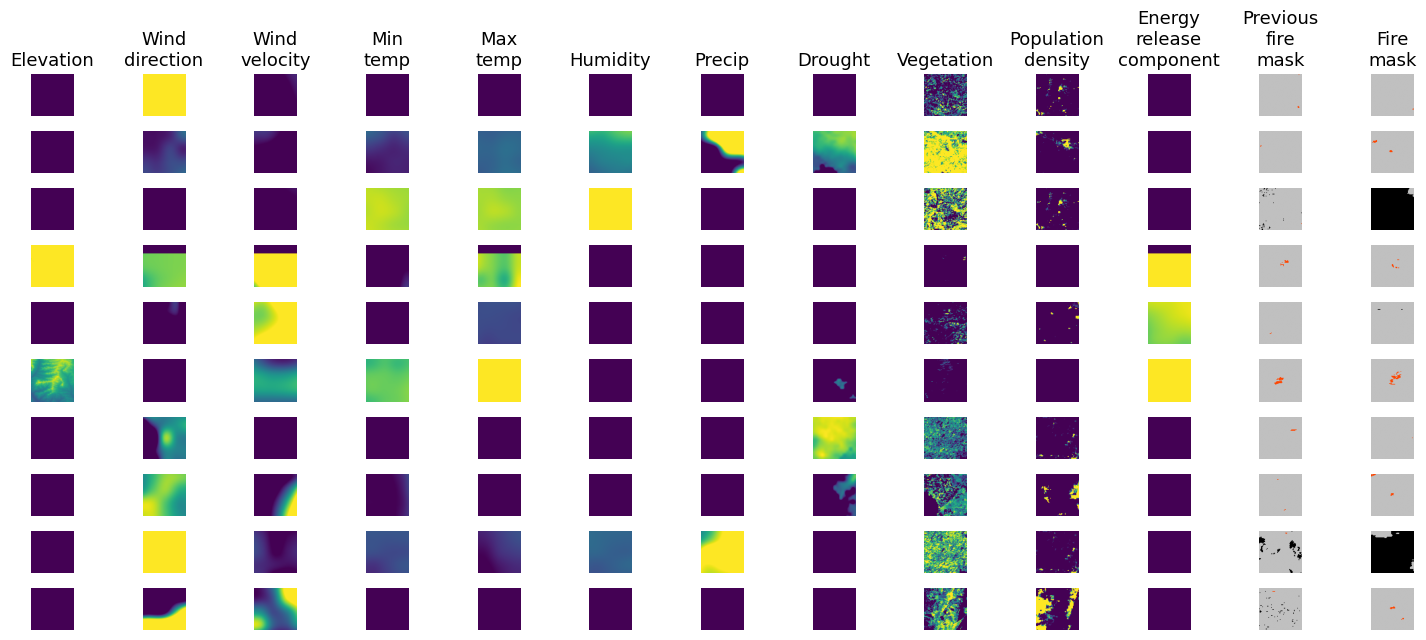

In [ ]:
visualise_n_samples( inputs=inputs, labels=labels, n_rows=10, show_sample=0, normalized=True)

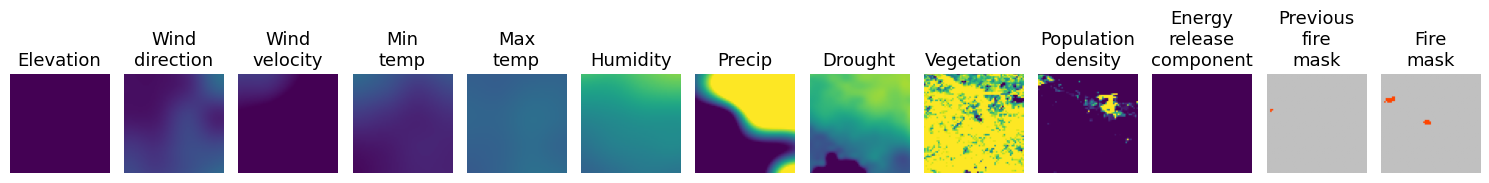

In [ ]:
visualise_n_samples( inputs=inputs, labels=labels, n_rows=1, show_sample=1, normalized=True)

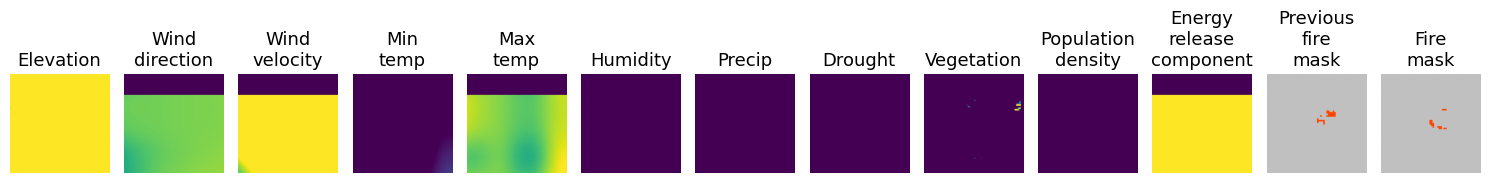

In [ ]:
visualise_n_samples( inputs=inputs, labels=labels, n_rows=1, show_sample=3, normalized=True)

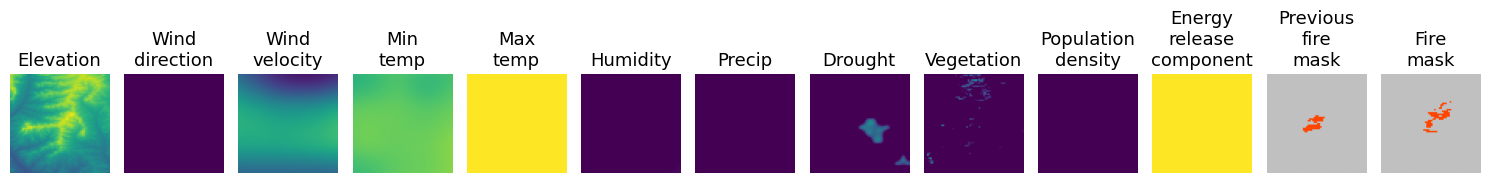

In [ ]:
visualise_n_samples( inputs=inputs, labels=labels, n_rows=1, show_sample=5, normalized=True)